In [1]:
import sys
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import sklearn 
import lightgbm
import xgboost


import warnings 
warnings.filterwarnings(action='ignore')

print('Python ==> ',sys.version)
print('Pandas ==>',pd.__version__)
print('Numpy ==>',np.__version__)
print('Scipy ==>',scipy.__version__)
print('Tensorflow ==> ',tf.__version__)
print('Scikit Learn ==> ',sklearn.__version__)
print('LightGBM ==>',lightgbm.__version__)
print('XGBoost ==>',xgboost.__version__)

Python ==>  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Pandas ==> 1.5.3
Numpy ==> 1.23.1
Scipy ==> 1.9.1
Tensorflow ==>  2.7.0
Scikit Learn ==>  1.2.2
LightGBM ==> 3.3.5
XGBoost ==> 1.7.4


In [2]:
modelBasePath = 'business_logic/models'

In [3]:
import os 
import re
import glob 
#import gc
#import psutil
import math
import pickle
import joblib
import scipy
import datetime
from datetime import datetime,timedelta
from bson.objectid import ObjectId
import pandas as pd
import numpy as np
from numpy import array
pd.set_option('display.max_columns', None)
import random
random.seed(1234)
np.random.seed(1234)
import datetime
from pymongo import MongoClient
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import warnings 
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

#### 1.) 실시간 DB 업로드 
- 원당 / Process / Optimal Settings 정보
- Process는 실시간 100개 조회 & 원당정보와 매칭 준비 

In [4]:
import gc
import psutil
def get_mongo_data(db_name, collection):
    server_address = "private_server_link"
    client_update = MongoClient(f"mongodb://PrivateDB@{server_address}/admin")
    try:
        db = client_update[db_name]
        if collection == 'sugar':
            col = db['RawSugarData']
            latest_record = col.find_one(sort=[("TimeStamp",-1)]) # Recent(Current) TimeStamp
            latest_timestamp = latest_record['TimeStamp']
            recent_data = list(col.find({'TimeStamp':latest_timestamp}))
            df = pd.DataFrame(recent_data)
            df['TimeStamp'] = df['TimeStamp'] + timedelta(hours=9)
            df = df.loc[df.groupby('TimeStamp')['PORT_DATE_S'].idxmax()].reset_index(drop=True) # Current Sugar Standard
            df = df.drop(['_id'],axis=1)
        elif collection == 'process':
            col = db['ProcData']
            cursor = col.find({}).sort('TimeStamp',-1).limit(100)  
            df = pd.DataFrame(cursor).sort_values(by='TimeStamp').reset_index(drop=True)
            cursor.close()  
            df = df.drop_duplicates(subset=['TimeStamp']).reset_index(drop=True)
            df['DateTime'] = df['DateTime'] + timedelta(hours=9)
            df['TimeStamp'] = df['TimeStamp'] + timedelta(hours=9)
            df['EV_02_FL_BRIX_value'] = ((df['EV_02_FL_BRIX_value']*df['EV_02_FL_FLOW_value']) + 
                                         (df['FL_TK_BX_PV_value']*df['FL_TK_P/P_F_value'])) / \
                                         (df['EV_02_FL_FLOW_value'] + df['FL_TK_P/P_F_value'])
            b = pd.DataFrame(df['SATURATOR2_CALCIUM_F_value'] / 1000 / df['SATURATOR2_ML_SUPPLY_F_PV_value'] / 0.03)
            df['SATURATOR2_CARBON_ratio'] = np.round(b, 2)
            df['_id'] = df['_id'].astype(str)
        elif collection =='val_settings':
            col = db['OptimalValueSetting']
            df = pd.DataFrame(list(col.find({}))).reset_index(drop=True)
            df = df[['_id','status','MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','CARORIFIER_S/T_TEMP_value',       
                'ML_TEMP_PV_value', 'MELTER_CONTROL_BX_value', 'CO2_GAS_F_value','CO2_GAS_PRESS_value', 'SATURATOR1_ML_SUPPLY_F_PV_value',        
                'SATURATOR1_PH_PV_value', 'SATURATOR2_ML_SUPPLY_F_PV_value','SATURATOR2_PH_PV_value', 'RF1_LIQUOR_SUPPLY_F_PV_value',        
                'RF2_LIQUOR_SUPPLY_F_PV_value', 'RF3_LIQUOR_SUPPLY_F_PV_value','RF4_LIQUOR_SUPPLY_F_PV_value','RF5_LIQUOR_SUPPLY_F_PV_value',  
                'RF6_LIQUOR_SUPPLY_F_PV_value', 'RF7_LIQUOR_SUPPLY_F_PV_value','RF8_LIQUOR_SUPPLY_F_PV_value','CISTERN1_BL_F_PV_value',        
                'CISTERN2_BL_F_PV_value', 'CISTERN3_BL_F_PV_value','CISTERN4_BL_F_PV_value', 'CISTERN5_BL_F_PV_value',
                'CISTERN6_BL_F_PV_value', 'CISTERN7_BL_F_PV_value','CISTERN8_BL_F_PV_value', 'CISTERN9_BL_F_PV_value',
                'CISTERN10_BL_F_PV_value', 'CISTERN11_BL_F_PV_value','SF1_CONTROL_PRESS_value', 'SF1_CONTROL_F_PV_value',
                'SF2_CONTROL_PRESS_value', 'SF2_CONTROL_F_PV_value','SF3_CONTROL_PRESS_value', 'SF3_CONTROL_F_PV_value',
                'SF4_CONTROL_PRESS_value', 'SF4_CONTROL_F_PV_value','SF5_CONTROL_PRESS_value', 'SF5_CONTROL_F_PV_value',
                'SF6_CONTROL_PRESS_value', 'SF6_CONTROL_F_PV_value', 'IER1_F_PV_value','IER1_CONTROL_VALVE_value','IER2_F_PV_value',
                'IER2_CONTROL_VALVE_value', 'IER3_F_PV_value','IER3_CONTROL_VALVE_value', 'IER4_F_PV_value','IER4_CONTROL_VALVE_value', 
                 'IER5_F_PV_value','IER5_CONTROL_VALVE_value', 'IER6_F_PV_value','IER6_CONTROL_VALVE_value', 'FL_TK_BX_PV_value', 'FL_TK_P/P_F_value',
                'EVA1_S/T_F_value', 'EVA_VACUMM_V/V_PV_value', 'EVA2_LEVEL_value','EV_01_PL_FLOW_value', '08FC0401_PV_value','EV_02_CONDENSER_VACCUM_value', 
                'EV_02_FL_BRIX_value']]
            dfs = []
            status = ['OptimalSedang','OptimalPochung','OptimalFirstFiltering','OptimalSecondRefining','OptimalSecondThirdFiltering',
            'OptimalThirdRefining','OptimalDoubleEffect','OptimalMVR']
            for status_value in status:
                optimal_settings = df[df['status']==status_value].tail(1).dropna(axis=1).reset_index(drop=True)
                optimal_settings = optimal_settings.drop(columns=['_id', 'status'], errors='ignore')  
                dfs.append(optimal_settings)
            if dfs:
                df = pd.concat(dfs,axis=1)
                df = df.loc[:,~df.columns.duplicated()]  
            else:
                df = pd.DataFrame()
            column_rename_map = {'RF1_LIQUOR_SUPPLY_F_PV_value': 'RF1_LIQUOR_SUPPLY_F_PV.value','RF2_LIQUOR_SUPPLY_F_PV_value': 'RF2_LIQUOR_SUPPLY_F_PV.value',
            'RF3_LIQUOR_SUPPLY_F_PV_value': 'RF3_LIQUOR_SUPPLY_F_PV.value','RF4_LIQUOR_SUPPLY_F_PV_value': 'RF4_LIQUOR_SUPPLY_F_PV.value',
            'RF5_LIQUOR_SUPPLY_F_PV_value': 'RF5_LIQUOR_SUPPLY_F_PV.value','RF6_LIQUOR_SUPPLY_F_PV_value': 'RF6_LIQUOR_SUPPLY_F_PV.value',
            'RF7_LIQUOR_SUPPLY_F_PV_value': 'RF7_LIQUER_SUPPLY_F_PV.value',  'RF8_LIQUOR_SUPPLY_F_PV_value': 'RF8_LIQUER_SUPPLY_F_PV.value',
            'SF1_CONTROL_F_PV_value':'SF1_CONTROL_F_PV.value','SF2_CONTROL_F_PV_value':'SF2_CONTROL_F_PV.value',
            'SF3_CONTROL_F_PV_value':'SF3_CONTROL_F_PV.value','SF1_CONTROL_PRESS_value':'SF1_BOTTOM_PRESS_PV.value',
             'SF2_CONTROL_PRESS_value':'SF2_BOTTOM_PRESS_PV.value','SF3_CONTROL_PRESS_value':'SF3_BOTTOM_PRESS_PV.value',
             'SF4_CONTROL_PRESS_value':'SF4_BOTTOM_PRESS_PV_value', 'SF5_CONTROL_PRESS_value':'SF5_PRESS_PV_value', 
             'SF6_CONTROL_PRESS_value':'SF6_PRESS_PV_value','IER6_F_PV_value':'IER6_FC_PV_value',
            'IER1_CONTROL_VALVE_value':'IER1_LIQUOR_LEVEL_value','IER2_CONTROL_VALVE_value': 'IER2_LIQUOR_LEVEL_value',
            'IER3_CONTROL_VALVE_value':'IER3_LIQUOR_LEVEL_value','IER4_CONTROL_VALVE_value':'IER4_LIQUOR_LEVEL_value',
            'IER5_CONTROL_VALVE_value':'IER5_LIQUOR_LEVEL_value','IER6_CONTROL_VALVE_value':'IER6_LC_PV_value'}
            df = df.rename(columns=column_rename_map)
        result_df = df
    finally:
        client_update.close()  
        gc.collect()  
        if 'df' in locals():
            del df
        if 'cursor' in locals():
            del cursor
        print('불필요한 메모리 점유 =', gc.collect()) 
        pid = os.getpid()
        process = psutil.Process(pid)
        print(f"Python 프로세스 메모리 사용량: {process.memory_info().rss / 1024**2:.2f} MB")
    return result_df

#### 2.) Column 정의
- 개별 공정 프로세스 단계별 Column 분리
- 실시간 수집데이터 비교 점검용 Column 정리
- 입력 공정조건 추천용 Column 정리 

In [6]:
def arrange_cols():

    #### 1.) 원당 
    cols_stage1 = ['COUNTRY','POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE']

    #### 2.) 세당 
    cols_stage2 = ['MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','MAGMA_MINGLER_TEMP_value',
                   'CARORIFIER_S/T_TEMP_value','ML_TEMP_PV_value','MELTER_CONTROL_BX_value']

    #### 3.) 포충 
    cols_stage3 = ['CO2_GAS_concentration_value','CO2_GAS_F_value','CO2_GAS_PRESS_value','SATURATOR1_CALCIUM_F_value',
                   'SATURATOR1_ML_SUPPLY_F_PV_value','SATURATOR1_PH_PV_value','SATURATOR2_CALCIUM_F_value',
                   'SATURATOR2_ML_SUPPLY_F_PV_value','SATURATOR2_PH_PV_value','SATURATOR2_CARBON_ratio','SATURATOR3_PH_PV_value',
                   'SATURATOR3_S/T_TEMP_value']

    #### 4.) 1,2차 여과 ~ 정제  
    cols_stage4 = ['RF1_LIQUOR_SUPPLY_F_PV.value','RF1_PRESS_PV.value','RF2_LIQUOR_SUPPLY_F_PV.value','RF2_PRESS_PV.value',
                   'RF3_LIQUOR_SUPPLY_F_PV.value','RF3_PRESS_PV.value','RF4_LIQUOR_SUPPLY_F_PV.value','RF4_PRESS_PV.value',
                   'RF5_LIQUOR_SUPPLY_F_PV.value','RF5_PRESS_PV.value','RF6_LIQUOR_SUPPLY_F_PV.value','RF6_PRESS_PV.value',
                   'RF7_LIQUER_SUPPLY_F_PV.value','RF7_PRESS_PV.value','RF8_LIQUER_SUPPLY_F_PV.value','RF8_PRESS_PV.value']
    cols_stage5 = ['CISTERN1_BL_F_PV_value','CISTERN1_PRESS_PV_value','CISTERN2_BL_F_PV_value','CISTERN2_PRESS_PV_value',
                   'CISTERN3_BL_F_PV_value','CISTERN3_PRESS_PV_value','CISTERN4_BL_F_PV_value','CISTERN4_PRESS_PV_value',
                   'CISTERN5_BL_F_PV_value','CISTERN5_PRESS_PV_value','CISTERN6_BL_F_PV_value','CISTERN6_PRESS_PV_value',
                   'CISTERN7_BL_F_PV_value','CISTERN7_PRESS_PV_value','CISTERN8_BL_F_PV_value','CISTERN8_PRESS_PV_value',
                   'CISTERN9_BL_F_PV_value','CISTERN9_PRESS_PV_value','CISTERN10_BL_F_PV_value','CISTERN10_PRESS_PV_value',
                   'CISTERN11_BL_F_PV_value','CISTERN11_PRESS_PV_value']
    cols_stage6 = ['SF1_BOTTOM_PRESS_PV.value','SF1_CONTROL_F_PV.value','SF2_BOTTOM_PRESS_PV.value','SF2_CONTROL_F_PV.value',
                   'SF3_BOTTOM_PRESS_PV.value','SF3_CONTROL_F_PV.value','SF4_BOTTOM_PRESS_PV_value','SF4_CONTROL_F_PV_value',
                   'SF5_PRESS_PV_value','SF5_CONTROL_F_PV_value','SF6_PRESS_PV_value','SF6_CONTROL_F_PV_value']
    cols_stage7 = ['IER1_F_PV_value','IER1_OUT_TEMP_value','IER1_PRESS_value','IER1_LIQUOR_LEVEL_value','IER2_F_PV_value',
                   'IER2_OUT_TEMP_value','IER2_PRESS_value','IER2_LIQUOR_LEVEL_value','IER3_F_PV_value','IER3_OUT_TEMP_value',
                   'IER3_PRESS_value','IER3_LIQUOR_LEVEL_value','IER4_F_PV_value','IER4_OUT_TEMP_value','IER4_PRESS_value',
                   'IER4_LIQUOR_LEVEL_value','IER5_F_PV_value','IER5_OUT_TEMP_value','IER5_PRESS_value','IER5_LIQUOR_LEVEL_value',
                   'IER6_FC_PV_value','IER6_TI_PV_value','IER6_PI_PV_value','IER6_LC_PV_value']

    #### 5.) 이중효용관 
    cols_stage8 = ['FL_TK_BX_PV_value','FL_TK_P/P_F_value','EVA1_S/T_F_value','08BC0103_PV_value','EVA1_PRESS_value',
                   'EVA_VACUMM_V/V_PV_value','EVA2_LEVEL_value','EVA2_TEMP_value']

    #### 6.) MVR 
    cols_stage9 = ['_id','DateTime','EV_01_LIQUEFIED_OUT_TEMP_value','EV_01_LIQUEFIED_RETURN_TEMP_value','EV_01_PL_FLOW_value','08FC0401_PV_value',
                 'EV_01_VAPOR_OUT_TEMP_value','EV_01_VAPOR_SEPARATOR_VACCUM_value','EV_02_CONDENSER_VACCUM_value',
                   'EV_02_FL_BRIX_value']

    #### 7.) 실시간 수집데이터 비교 점검용 항목 정리 
    analysis_cols = ['DateTime','PORT_DATE_S','COUNTRY','POL', 'ISS', 'MOIST', 'FRATE', 'ASH', 'CVIU', 'STARCH', 'HAZE', '_id', 'TimeStamp', 'RF1_LIQUOR_SUPPLY_F_PV.value', 
                'RF1_PRESS_PV.value', 'RF2_LIQUOR_SUPPLY_F_PV.value', 'RF2_PRESS_PV.value', 'RF3_LIQUOR_SUPPLY_F_PV.value', 'RF3_PRESS_PV.value', 'RF4_LIQUOR_SUPPLY_F_PV.value',
                'RF4_PRESS_PV.value', 'RF5_LIQUOR_SUPPLY_F_PV.value', 'RF5_PRESS_PV.value', 'RF6_LIQUOR_SUPPLY_F_PV.value', 'RF6_PRESS_PV.value', 'RF7_LIQUER_SUPPLY_F_PV.value', 
                'RF7_PRESS_PV.value', 'RF8_LIQUER_SUPPLY_F_PV.value','RF8_PRESS_PV.value', 'SF1_BOTTOM_PRESS_PV.value', 'SF1_CONTROL_F_PV.value', 'SF2_BOTTOM_PRESS_PV.value', 
                'SF2_CONTROL_F_PV.value', 'SF3_BOTTOM_PRESS_PV.value', 'SF3_CONTROL_F_PV.value', 'SF4_BOTTOM_PRESS_PV_value','SF4_CONTROL_F_PV_value', 'SF5_CONTROL_F_PV_value', 
                'SF5_PRESS_PV_value', 'SF6_CONTROL_F_PV_value', 'SF6_PRESS_PV_value', '08BC0103_PV_value', '08FC0401_PV_value', 'EVA1_PRESS_value', 'EVA1_S/T_F_value', 'EVA_VACUMM_V/V_PV_value',
                'EVA2_LEVEL_value', 'EVA2_TEMP_value', 'FL_TK_BX_PV_value', 'FL_TK_P/P_F_value','CARORIFIER_S/T_TEMP_value', 'MAGMA_HEATER_TEMP_PV_value', 'MAGMA_MINGLER_AMP_value', 
                'MAGMA_MINGLER_TEMP_value','MELTER_CONTROL_BX_value', 'ML_TEMP_PV_value', 'IER1_F_PV_value', 'IER1_LIQUOR_LEVEL_value', 'IER1_OUT_TEMP_value', 'IER1_PRESS_value', 'IER2_F_PV_value',
                'IER2_LIQUOR_LEVEL_value', 'IER2_OUT_TEMP_value','IER2_PRESS_value', 'IER3_F_PV_value', 'IER3_LIQUOR_LEVEL_value', 'IER3_OUT_TEMP_value', 'IER3_PRESS_value', 'IER4_F_PV_value', 
                'IER4_LIQUOR_LEVEL_value', 'IER4_OUT_TEMP_value', 'IER4_PRESS_value', 'IER5_F_PV_value','IER5_LIQUOR_LEVEL_value', 'IER5_OUT_TEMP_value', 'IER5_PRESS_value', 'IER6_FC_PV_value', 
                'IER6_LC_PV_value', 'IER6_PI_PV_value', 'IER6_TI_PV_value', 'CISTERN10_BL_F_PV_value', 'CISTERN10_PRESS_PV_value', 'CISTERN11_BL_F_PV_value', 
                'CISTERN11_PRESS_PV_value', 'CISTERN1_BL_F_PV_value', 'CISTERN1_PRESS_PV_value', 'CISTERN2_BL_F_PV_value', 'CISTERN2_PRESS_PV_value', 'CISTERN3_BL_F_PV_value', 'CISTERN3_PRESS_PV_value', 
                'CISTERN4_BL_F_PV_value', 'CISTERN4_PRESS_PV_value','CISTERN5_BL_F_PV_value', 'CISTERN5_PRESS_PV_value', 'CISTERN6_BL_F_PV_value','CISTERN6_PRESS_PV_value', 'CISTERN7_BL_F_PV_value',
                'CISTERN7_PRESS_PV_value', 'CISTERN8_BL_F_PV_value', 'CISTERN8_PRESS_PV_value', 'CISTERN9_BL_F_PV_value', 'CISTERN9_PRESS_PV_value', 'SATURATOR1_CALCIUM_F_value', 'SATURATOR1_ML_SUPPLY_F_PV_value', 
                'SATURATOR1_PH_PV_value', 'SATURATOR2_CALCIUM_F_value', 'SATURATOR2_ML_SUPPLY_F_PV_value', 'SATURATOR2_PH_PV_value', 'SATURATOR3_PH_PV_value', 'SATURATOR3_S/T_TEMP_value', 'CO2_GAS_concentration_value',
                'CO2_GAS_F_value', 'CO2_GAS_PRESS_value', 'EV_01_LIQUEFIED_OUT_TEMP_value', 'EV_01_LIQUEFIED_RETURN_TEMP_value',
                'EV_01_PL_FLOW_value', 'EV_01_VAPOR_OUT_TEMP_value', 'EV_01_VAPOR_SEPARATOR_VACCUM_value', 'EV_02_CONDENSER_VACCUM_value', 'EV_02_FL_BRIX_value', 'EV_02_FL_FLOW_value', 'EV_02_LEVEL_value', 
                'EV_02_LIQUEFIED_OUT_TEMP_value', 'EV_02_MVR02_VAPOR_TEMP_value', 'SATURATOR2_CARBON_ratio']

    #### 8.) 공정조건 추론용 대상 항목 정리 
    recipe_cols = ['_id','DateTime', 'COUNTRY', 'POL', 'ISS', 'MOIST', 'FRATE', 'ASH', 'CVIU','STARCH', 'HAZE', 
                 'MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value', 'CARORIFIER_S/T_TEMP_value',
                'ML_TEMP_PV_value', 'MELTER_CONTROL_BX_value', 'CO2_GAS_F_value','CO2_GAS_PRESS_value', 
                 'SATURATOR1_ML_SUPPLY_F_PV_value','SATURATOR1_PH_PV_value', 'SATURATOR2_ML_SUPPLY_F_PV_value',
                'SATURATOR2_PH_PV_value', 'RF1_LIQUOR_SUPPLY_F_PV.value','RF2_LIQUOR_SUPPLY_F_PV.value', 
                 'RF3_LIQUOR_SUPPLY_F_PV.value','RF4_LIQUOR_SUPPLY_F_PV.value', 'RF5_LIQUOR_SUPPLY_F_PV.value',
                'RF6_LIQUOR_SUPPLY_F_PV.value', 'RF7_LIQUER_SUPPLY_F_PV.value','RF8_LIQUER_SUPPLY_F_PV.value',
                'CISTERN1_BL_F_PV_value','CISTERN2_BL_F_PV_value', 'CISTERN3_BL_F_PV_value',
                'CISTERN4_BL_F_PV_value', 'CISTERN5_BL_F_PV_value','CISTERN6_BL_F_PV_value', 'CISTERN7_BL_F_PV_value',
                'CISTERN8_BL_F_PV_value', 'CISTERN9_BL_F_PV_value','CISTERN10_BL_F_PV_value', 'CISTERN11_BL_F_PV_value',
                'SF1_BOTTOM_PRESS_PV.value', 'SF1_CONTROL_F_PV.value','SF2_BOTTOM_PRESS_PV.value', 'SF2_CONTROL_F_PV.value',
                'SF3_BOTTOM_PRESS_PV.value', 'SF3_CONTROL_F_PV.value','SF4_BOTTOM_PRESS_PV_value', 'SF4_CONTROL_F_PV_value',
                'SF5_PRESS_PV_value', 'SF5_CONTROL_F_PV_value', 'SF6_PRESS_PV_value','SF6_CONTROL_F_PV_value', 
                'IER1_F_PV_value', 'IER1_LIQUOR_LEVEL_value','IER2_F_PV_value', 'IER2_LIQUOR_LEVEL_value',
                'IER3_F_PV_value','IER3_LIQUOR_LEVEL_value', 'IER4_F_PV_value', 'IER4_LIQUOR_LEVEL_value',
                'IER5_F_PV_value', 'IER5_LIQUOR_LEVEL_value', 'IER6_FC_PV_value','IER6_LC_PV_value', 
                'FL_TK_BX_PV_value', 'FL_TK_P/P_F_value','EVA1_S/T_F_value', 'EVA_VACUMM_V/V_PV_value',
                 'EVA2_LEVEL_value','EV_01_PL_FLOW_value', '08FC0401_PV_value','EV_02_CONDENSER_VACCUM_value', 'EV_02_FL_BRIX_value']
    return cols_stage1,cols_stage2,cols_stage3,cols_stage4,cols_stage5,cols_stage6,cols_stage7,cols_stage8,cols_stage9,analysis_cols,recipe_cols

#### 3.) 입력용 데이터 정의  

In [7]:
def get_data_by_id(_id):
    #### 1.) 현재 원당 고정 정보 + 실시간 100개 Process 데이터 결합 
    df_sugar = get_mongo_data('PrivateDB','sugar')
    df_process = get_mongo_data('PrivateDB','process')
    df_process = df_process.loc[:,~df_process.columns.str.contains('_predicted')]
    if all(item in df_process.columns.tolist() for item in ['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE','RF 통합유량','SF 통합유량','수지 통합유량']):
        df_process.drop(['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE','RF 통합유량','SF 통합유량','수지 통합유량'],axis=1,inplace=True)
    else:
        pass
    df_process[['PORT_DATE_S','COUNTRY','POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE']] = df_sugar[['PORT_DATE_S','COUNTRY','POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE']] 
    df_process[['PORT_DATE_S','COUNTRY','POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE']] = df_process[['PORT_DATE_S','COUNTRY','POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE']].fillna(method='ffill').fillna(method='bfill')
    df_raw_sugar = df_process[['PORT_DATE_S','COUNTRY','POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE']]
    df_concat = pd.concat([df_raw_sugar,df_process[df_process.columns.tolist()[:-10]]],axis=1)
    df_concat = pd.concat([df_concat[['DateTime']],df_concat.drop(['DateTime'],axis=1)],axis=1)
    df_concat['_id'] = df_concat['_id'].astype(str)
    
    #### 2.) 개별 공정 프로세스 / 실시간 수집데이터 비교 점검용  / 공정조건 추론용 Column 정의 이후 현재 실시간 데이터 Column 점검 
    cols_stage1,cols_stage2,cols_stage3,cols_stage4,cols_stage5,cols_stage6,cols_stage7,cols_stage8,cols_stage9,analysis_cols,recipe_cols = arrange_cols()
    if set(df_concat.columns.tolist()) != set(analysis_cols):
        df_concat = df_concat[analysis_cols]
    else:
        print('Column Match')
        pass
    
    ## 3.) 100개 데이터 중 가장 최근 Data _Id인 Current_Input 1개 행 정의  
    df_concat = df_concat[cols_stage1+cols_stage2+cols_stage3+cols_stage4+cols_stage5+cols_stage6+cols_stage7+cols_stage8+cols_stage9]
    reconstruct_inputs = df_concat[recipe_cols]
    current_input = reconstruct_inputs[reconstruct_inputs['_id']==_id].reset_index(drop=True)
    current_inputs = current_input.drop(['_id'],axis=1)

    #### 4.) 포충공정의 1,2탑 ML공급유량 예측용 N X D 데이터 정의 ( 공정 시차지연 적용 시도 & 제약조건 충족 X 시 적용 취소 )
    df1_a = df_concat[cols_stage1].shift(10)
    df2_a = df_concat[cols_stage2].shift(6)             
    df3_a = df_concat[cols_stage3]       
    df_concat2_A = pd.concat([df1_a,df2_a,df3_a],axis=1).reset_index(drop=True)
    df_concat2_A = df_concat2_A.dropna().reset_index(drop=True)
    if len(df_concat2_A)<20:
        df_concat2_A = df_concat[cols_stage1+cols_stage2+cols_stage3]
    else:
        pass

    #### 5.) MVR공정의 FL_BRIX농도 예측용 N X D 데이터 정의 ( 공정 시차지연 적용 시도 & 제약조건 충족 X 시 적용 취소 )
    df1 = df_concat[cols_stage1].shift(34)
    df2 = df_concat[cols_stage2].shift(30)             
    df3 = df_concat[cols_stage3].shift(24)          
    df4 = df_concat[cols_stage4].shift(24)                    
    df5 = df_concat[cols_stage5].shift(12)          
    df6 = df_concat[cols_stage6].shift(12)                  
    df7 = df_concat[cols_stage7].shift(6)          
    df8 = df_concat[cols_stage8]          
    df9 = df_concat[cols_stage9]         
    df_concat2_B = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9],axis=1).reset_index(drop=True)
    df_concat2_B = df_concat2_B.dropna().reset_index(drop=True)
    df_concat2_B = df_concat2_B[(df_concat2_B['EV_02_FL_BRIX_value']>=60)&(df_concat2_B['EV_02_FL_BRIX_value']<=80)].reset_index(drop=True)
    if len(df_concat2_B)>0:
        if _id not in df_concat2_B['_id'].iloc[-1]:
            df_concat2_B = df_concat
        else:
            pass
    else:
        df_concat2_B = df_concat
    if len(df_concat2_B)<20:
        df_concat2_B = df_concat
    else:
        pass
    
    #### 6.) ML공급유량 1,2 & FL_BRIX 예측용 Column 최종 정의 
    ml_bx_1_cols = ['MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','CARORIFIER_S/T_TEMP_value',
                  'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value',
                  'CO2_GAS_PRESS_value','SATURATOR1_CALCIUM_F_value','SATURATOR1_PH_PV_value','SATURATOR1_ML_SUPPLY_F_PV_value']
    ml_bx_2_cols = ['MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','CARORIFIER_S/T_TEMP_value',
                  'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value',
                  'CO2_GAS_PRESS_value','SATURATOR2_CALCIUM_F_value','SATURATOR2_PH_PV_value','SATURATOR2_CARBON_ratio',
                  'SATURATOR2_ML_SUPPLY_F_PV_value']
    fl_bx_cols = ['MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','MAGMA_MINGLER_TEMP_value','CARORIFIER_S/T_TEMP_value',
                 'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value','CO2_GAS_PRESS_value',
                  'SATURATOR1_ML_SUPPLY_F_PV_value','SATURATOR1_PH_PV_value','SATURATOR2_ML_SUPPLY_F_PV_value','SATURATOR2_PH_PV_value',
                  'FL_TK_BX_PV_value','FL_TK_P/P_F_value','EVA1_S/T_F_value','08BC0103_PV_value','EVA1_PRESS_value','EVA_VACUMM_V/V_PV_value',
                  'EVA2_LEVEL_value','EVA2_TEMP_value','EV_01_LIQUEFIED_OUT_TEMP_value','EV_01_LIQUEFIED_RETURN_TEMP_value','EV_01_PL_FLOW_value',
                  '08FC0401_PV_value','EV_01_VAPOR_OUT_TEMP_value','EV_01_VAPOR_SEPARATOR_VACCUM_value','EV_02_CONDENSER_VACCUM_value',
                  'EV_02_FL_BRIX_value']

    #### 7.) Tree모델 기반 ML예측용 입력데이터 정의 (마지막 1개 행 )
    df_MLBX1_inputs = df_concat2_A[ml_bx_1_cols].iloc[-1:].reset_index(drop=True) # .iloc[:]
    df_MLBX2_inputs = df_concat2_A[ml_bx_2_cols].iloc[-1:].reset_index(drop=True) # .iloc[:]
    df_FLBX_inputs = df_concat2_B[fl_bx_cols].iloc[-1:].reset_index(drop=True)   # .iloc[:]
    
    #### 8.) DL모델 기반 예측용 입력데이터 정의 (학습된 TimeStamp만큼 마지막 시점으로부터  N X D 형태 )
    df_MLBX1_dl_inputs = df_concat2_A[ml_bx_1_cols].iloc[-14:].reset_index(drop=True)
    df_MLBX2_dl_inputs = df_concat2_A[ml_bx_2_cols].iloc[-20:].reset_index(drop=True)
    df_FLBX_dl_inputs = df_concat2_B[fl_bx_cols].iloc[-14:].reset_index(drop=True)
    
    #### 9.) 최근 100개 품질의 개별 표준편차 / 평균 / 변동계수 계산
    recent_mlbx1_std = df_process['SATURATOR1_ML_SUPPLY_F_PV_value'].std()
    recent_mlbx2_std = df_process['SATURATOR2_ML_SUPPLY_F_PV_value'].std()
    recent_flbx_std = df_process['EV_02_FL_BRIX_value'].std()

    recent_mlbx1_mean = df_process['SATURATOR1_ML_SUPPLY_F_PV_value'].mean()
    recent_mlbx2_mean = df_process['SATURATOR2_ML_SUPPLY_F_PV_value'].mean()
    recent_flbx_mean = df_process['EV_02_FL_BRIX_value'].mean()

    recent_mlbx1_cv = (df_process['SATURATOR1_ML_SUPPLY_F_PV_value'].std()/df_process['SATURATOR1_ML_SUPPLY_F_PV_value'].mean())*100
    recent_mlbx2_cv = (df_process['SATURATOR2_ML_SUPPLY_F_PV_value'].std()/df_process['SATURATOR2_ML_SUPPLY_F_PV_value'].mean())*100
    recent_flbx_cv = (df_process['EV_02_FL_BRIX_value'].std()/df_process['EV_02_FL_BRIX_value'].mean())*100

    #### 10.) 기존 학습데이터 기준 품질값들의 변동계수 참고하여 실시간 100개 품질의 표준편차 보정 
    def adjusted_std(std,cv,cv_ref,mean):
        if cv <= cv_ref:
            return std
        else:
            alpha=0.7
            return alpha*std+(1-alpha)*(0.1*mean)
    cv_ref = [ 10, 10, 1.5 ] 
    recent_mlbx1_std = adjusted_std(recent_mlbx1_std,recent_mlbx1_cv,cv_ref[0],recent_mlbx1_mean)
    recent_mlbx2_std = adjusted_std(recent_mlbx2_std,recent_mlbx2_cv,cv_ref[1],recent_mlbx2_mean)
    recent_flbx_std = adjusted_std(recent_flbx_std,recent_flbx_cv,cv_ref[1],recent_flbx_mean)
    
    return df_MLBX1_inputs,df_MLBX2_inputs,df_FLBX_inputs,df_MLBX1_dl_inputs,df_MLBX2_dl_inputs,df_FLBX_dl_inputs,current_inputs,recent_mlbx1_std,recent_mlbx2_std,recent_flbx_std

#### 4.) 최적 생산조건 추천용 데이터 전처리 
- 과거 예측모델 구축 당시에 활용했던 전체 데이터셋 정의
- Original 전체 데이터 정의 
- val_settings ( 사용자 정의 각 공정조건 Min/Max범위 필터링된 데이터 추가 정의 )

In [35]:
def load_trained_data():
    #### 1.) 기존 전체 과거 공정조건 Recipe Data 업로드 
    chunks = pd.read_csv('Data/Recipe_Data.csv',encoding='cp949',chunksize=10000)
    df_list = []  
    for chunk in chunks:
        df_list.append(chunk)  
    df = pd.concat(df_list,ignore_index=True)  
    df['ML_SUPPLY_F_PV_diff'] = (df['SATURATOR1_ML_SUPPLY_F_PV_value'] - df['SATURATOR2_ML_SUPPLY_F_PV_value']).abs()
    df = df[df['ML_SUPPLY_F_PV_diff']<10].drop(['ML_SUPPLY_F_PV_diff'],axis=1).sort_values(by='DateTime').reset_index(drop=True)
    df = df[df['SATURATOR1_ML_SUPPLY_F_PV_value']>=20].reset_index(drop=True)
    df = df[(df['EV_02_FL_BRIX_value']>=60)&(df['EV_02_FL_BRIX_value']<=80)].reset_index(drop=True)
    df = df.drop_duplicates(subset=['DateTime'],keep='first').reset_index(drop=True)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['DateTime'] = df['DateTime'].dt.floor('S')
    df = df.sort_values(by='DateTime',ascending=True).reset_index(drop=True)
    df_original = df

    #### 2.) 현재 val_settings Collection에서 정의된 각 공정조건 최대/최소 범위 추가 필터링 
    df_copy = df.copy()
    df_optimal_settings = get_mongo_data('PrivateDB','val_settings')
    conditions = []
    for col in df_optimal_settings.columns:
        raw_value = str(df_optimal_settings[col].iloc[0])  
        raw_value = raw_value.replace("{", "").replace("}", "") 
        value_pairs = dict(item.split(":") for item in raw_value.split(",") if ":" in item)
        min_value = value_pairs.get("'min_value'", "").strip().replace("'","")
        max_value = value_pairs.get(" 'max_value'", "").strip().replace("'","")
        min_value = float(min_value) if min_value.lstrip('-').replace('.', '', 1).isdigit() else None
        max_value = float(max_value) if max_value.lstrip('-').replace('.', '', 1).isdigit() else None
        if min_value is not None and max_value is None:
            set_condition = (df_copy[col]>=min_value)
        elif min_value is None and max_value is not None:
            set_condition = (df_copy[col]<=max_value)
        elif min_value is not None and max_value is not None:
            set_condition = (df_copy[col]>=min_value)&(df[col]<=max_value)
        elif min_value is None and max_value is None:
            pass
        else:
            continue
        conditions.append(set_condition)
    if conditions:
        condition_intersection = conditions[0]  
        for cond in conditions[1:]:  
            condition_intersection &= cond 
    df_copy = df_copy[condition_intersection].reset_index(drop=True)
    if len(df_copy)==0:
        df = df
    else:
        df = df_copy
    drop_cols = ['SF1_BOTTOM_PRESS_PV.value','SF2_BOTTOM_PRESS_PV.value','SF3_BOTTOM_PRESS_PV.value','SF4_BOTTOM_PRESS_PV_value',
            'SF5_PRESS_PV_value','SF6_PRESS_PV_value',
            'IER1_LIQUOR_LEVEL_value','IER2_LIQUOR_LEVEL_value','IER3_LIQUOR_LEVEL_value','IER4_LIQUOR_LEVEL_value',
            'IER5_LIQUOR_LEVEL_value','IER6_LC_PV_value']
    df = df.drop(drop_cols,axis=1)
    df_original = df_original.drop(drop_cols,axis=1)
    return df_optimal_settings , df , df_original

#### 4.) 최적 생산조건 추천용 데이터 전처리 2
- 현재 입력값의 최근접 원당 특징을 가진 과거 학습데이터 부분 선별 

In [9]:
def preprocess_sugar_condition(input_data):
    #### 1.) 과거 최적생산조건 추론용 데이터 (Recipe Data) 업로드 [Original & Val_Settings기반 필터링 결과 각각 활용 ]
    df_optimal_settings , Recipe_Info , Recipe_Full = load_trained_data()

    #### 2.) 현재 실시간 수집 최근 데이터의 원산지 정보 확인 
    country = input_data['COUNTRY'].values[0]
    if country not in ['AU','TH']:
        country = 'OT'  
    else:
        pass

    #### 3.) Val Settings기반 필터링된 Recipe Data에서 현재 입력데이터의 원산지 정보에 해당하는 데이터 선택 
    df_origin = Recipe_Info[Recipe_Info['COUNTRY']==country].reset_index(drop=True).drop(['COUNTRY'],axis=1)
    df_copy = Recipe_Info.copy()
    df_copy['COUNTRY'] = df_copy['COUNTRY'].replace({'AU':1,'TH':2,'OT':3})

    #### 4.) [원산지 + 원당통합정보] 수치정보 기반 군집학습 & 현재 입력데이터의 군집번호 예측  
    set_cols = ['COUNTRY','POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE']
    n = len(df_copy[set_cols].drop_duplicates())
    pipe1 = Pipeline([('scaler', StandardScaler()),('kmeans',KMeans(n_clusters=n,random_state=2021))])
    df_copy['cluster_no'] = pipe1.fit_predict(df_copy[set_cols])
    cluster_counts = df_copy['cluster_no'].value_counts().to_dict()
    input_data_copy = input_data.copy()
    print('현재 원당 ==> ',input_data_copy['COUNTRY'].iloc[-1])
    if country=='AU':
        input_data_copy['COUNTRY'] = 1
    elif country=='TH':
        input_data_copy['COUNTRY'] = 2
    else:
        input_data_copy['COUNTRY'] = 3
    pred_cluster = pipe1.predict(input_data_copy[set_cols].values)[0]

    #### 5.) 예측된 군집번호에 해당하는 K-Means 학습데이터 개수 점검 & 최소 개수 충족 X 시 현재 군집 외에 최근접 군집 데이터 선택   
    def select_best_cluster(pred_cluster,cluster_counts):
        if cluster_counts.get(pred_cluster,0)>=50:
            return pred_cluster 
        else:
            kmeans_model = pipe1.named_steps['kmeans']
            input_scaled = pipe1.named_steps['scaler'].transform(input_data_copy[set_cols].values.reshape(1, -1))
            distances = np.linalg.norm(kmeans_model.cluster_centers_ - input_scaled, axis=1) # Euclidean Distance 
            sorted_clusters = [i for i in np.argsort(distances) if i != pred_cluster]
            for cluster in sorted_clusters:
                if cluster_counts.get(cluster,0)>=50:
                    return cluster
    best_cluster = select_best_cluster(pred_cluster,cluster_counts)
    df_cluster = df_copy[df_copy['cluster_no'] == best_cluster].drop(['COUNTRY','cluster_no'],axis=1).reset_index(drop=True)

    #### 6.) 기존 원산지 기반 데이터 df_origin에 df_cluster데이터 정보 포함하도록 추가 확인 
    df_origin = df_origin.merge(df_cluster,how='left',indicator=True).query('_merge == "left_only"').drop('_merge', axis=1).reset_index(drop=True)
    print('=================================================================================================')
    print('load data --> set optimals --> split [cluster / origin] --> Optimizer data ready')
    print('================================================================================================')

    Recipe_Full = Recipe_Full.drop(['COUNTRY'],axis=1)            
    Recipe_Info = Recipe_Info.drop(['COUNTRY'],axis=1)
    
    return Recipe_Full , df_optimal_settings, Recipe_Info, df_cluster, df_origin

#### 5.) 목표값 대비 최근접 과거학습 다변량 공정조건 데이터 탐색 
- ML유량1,2 & FL_BRIX 농도 사용자 정의 목표값 대비 최근접 과거데이터 조합 탐색
- df_origin / df_cluster데이터로부터 경로탐색 설정 가능 

In [10]:
#### 1.) 목표값 대비 최근접 품질값을 df_origin(원산지 상위 집합) or df_cluster(원산지+원당 군집 정보) 기반 
def find_closest_value(df_method,col,target):
    first_value = df_method.iloc[(df_method[col]-target).abs().argsort()[:1]][col].iloc[-1]
    if first_value < target:
        extra_values = df_method[df_method[col]>=target].reset_index(drop=True)
        if len(extra_values)!=0:
            corrected_value = extra_values.iloc[(extra_values[col]-target).abs().argsort()[:1]][col].iloc[-1]
        else:
            corrected_value = first_value
    else:
        corrected_value = first_value
    return corrected_value

#### 2.) 목표값 대비 최근접 품질값을 df_origin(원산지 상위 집합) or df_cluster(원산지+원당 군집 정보) 기반 
def triple_search_condition(df_method,closest_MLBX1,closest_MLBX2,closest_FLBX):
    #### 1.) ML공급유량1,2 --> FL_BRIX농도 탐색 방향 
    df_condition = df_method[(df_method['SATURATOR1_ML_SUPPLY_F_PV_value']>=closest_MLBX1)&(df_method['SATURATOR2_ML_SUPPLY_F_PV_value']>=closest_MLBX2)]
    if df_condition['EV_02_FL_BRIX_value'].max()<closest_FLBX:
        df_condition = df_method[(df_method['SATURATOR1_ML_SUPPLY_F_PV_value']>=closest_MLBX1)|(df_method['SATURATOR2_ML_SUPPLY_F_PV_value']>=closest_MLBX2)] 
    else:
        pass
    flbx_condition = df_condition[df_condition['EV_02_FL_BRIX_value']>=closest_FLBX]
    if len(flbx_condition)!=0:  
        bx_targets = flbx_condition.iloc[(flbx_condition['EV_02_FL_BRIX_value']-closest_FLBX).abs().argsort()]['EV_02_FL_BRIX_value'].values.tolist()
        if len(bx_targets)==0:
            condition1 = pd.DataFrame()
        else:
            def MAPE(y,pred):
                return np.mean(np.abs((y-pred)/y)*100)  
            result_df =pd.DataFrame({'preds': bx_targets})
            result_df['mape'] = result_df['preds'].apply(lambda x:MAPE(x,closest_FLBX))
            target_fl_bx = result_df.loc[result_df['mape'].idxmin(),'preds']
            condition1 = df_condition[df_condition['EV_02_FL_BRIX_value']==target_fl_bx].reset_index(drop=True)
    else:
        condition1 = pd.DataFrame()
    #### 2.) FL_BRIX --> ML공급유량1,2 탐색 방향 
    mlbx_condition = df_method[(df_method['EV_02_FL_BRIX_value']>=closest_FLBX)] 
    if len(mlbx_condition)!=0:
        mlbx1_targets = mlbx_condition[mlbx_condition['SATURATOR1_ML_SUPPLY_F_PV_value']>=closest_MLBX1]['SATURATOR1_ML_SUPPLY_F_PV_value'].values.tolist()
        if len(mlbx1_targets)==0:
            condition2 = pd.DataFrame()
        else:
            def MAPE(y,pred):
                return np.mean(np.abs((y-pred)/y)*100)  
            result_df =pd.DataFrame({'preds': mlbx1_targets})
            result_df['mape'] = result_df['preds'].apply(lambda x:MAPE(x,closest_MLBX1))
            target_mlbx1 = result_df.loc[result_df['mape'].idxmin(),'preds']
            condition2 = df_condition[df_condition['SATURATOR1_ML_SUPPLY_F_PV_value']==target_mlbx1].reset_index(drop=True)
        mlbx2_targets = mlbx_condition[mlbx_condition['SATURATOR2_ML_SUPPLY_F_PV_value']>=closest_MLBX2]['SATURATOR2_ML_SUPPLY_F_PV_value'].values.tolist()
        if len(mlbx2_targets)==0:
            condition3 = pd.DataFrame()
        else:
            def MAPE(y,pred):
                return np.mean(np.abs((y-pred)/y)*100)  
            result_df =pd.DataFrame({'preds': mlbx2_targets})
            result_df['mape'] = result_df['preds'].apply(lambda x:MAPE(x,closest_MLBX2))
            target_mlbx2 = result_df.loc[result_df['mape'].idxmin(),'preds']
            condition3 = df_condition[df_condition['SATURATOR2_ML_SUPPLY_F_PV_value']==target_mlbx2].reset_index(drop=True)
    else:
        condition2 = pd.DataFrame()
        condition3 = pd.DataFrame()
    triple_condition = pd.concat([condition1,condition2,condition3],axis=0).reset_index(drop=True)
    return triple_condition

#### 6.) 공정조건 탐색 예외처리 검토 

In [11]:
#### 1.) df_origin / df_cluster로부터 목표 기반 최근접 품질값 선택 & 공정조건 탐색 
def triple_condition_sugar_refine(input_data,target1,target2,target3,df_method):
    closest_MLBX1 = find_closest_value(df_method,'SATURATOR1_ML_SUPPLY_F_PV_value',target1)
    closest_MLBX2 = find_closest_value(df_method,'SATURATOR2_ML_SUPPLY_F_PV_value',target2)
    closest_FLBX = find_closest_value(df_method,'EV_02_FL_BRIX_value',target3)
    triple_condition = triple_search_condition(df_method,closest_MLBX1,closest_MLBX2 ,closest_FLBX)
    return closest_MLBX1,closest_MLBX2,closest_FLBX,triple_condition

#### 2.) triple_condition=0일때, 기존 전체집합 Recipe_Full / Val Setting 필터링 기반 Recipe_Info로부터 조건 탐색 
def exception_handling(Recipe_Info,Recipe_Full,triple_condition,closest_MLBX1,closest_MLBX2,closest_FLBX,search_method):
    triple_condition = triple_condition
    print('현재 원당기반 탐색조건 실패 ('+str(search_method)+') ==> 상위데이터 탐색')
    #### 1.) ML공급유량1,2 & FL_BRIX 농도 (40,40,75)이상인 과거 공정조건 중 1개 무작위 선택  
    Recipe_Info = Recipe_Info
    new_condition_A = Recipe_Info[(Recipe_Info['SATURATOR1_ML_SUPPLY_F_PV_value']>=40)&
                   (Recipe_Info['SATURATOR2_ML_SUPPLY_F_PV_value']>=40)&
                   (Recipe_Info['EV_02_FL_BRIX_value']>=75)].reset_index(drop=True)
    if len(new_condition_A)==0:
        new_condition_A = Recipe_Full[(Recipe_Full['SATURATOR1_ML_SUPPLY_F_PV_value']>=40)&
                   (Recipe_Full['SATURATOR2_ML_SUPPLY_F_PV_value']>=40)&
                   (Recipe_Full['EV_02_FL_BRIX_value']>=75)].reset_index(drop=True)
    else:
        pass
    df1 = new_condition_A.sample(n=1).reset_index(drop=True)

    #### 2.) ML공급유량1,2 & FL_BRIX 농도의 최근접 품질값에 대응하는 과거 공정조건 중 1개 무작위 선택 
    new_condition_B = Recipe_Info[(Recipe_Info['SATURATOR1_ML_SUPPLY_F_PV_value']>=closest_MLBX1)&
                       (Recipe_Info['SATURATOR2_ML_SUPPLY_F_PV_value']>=closest_MLBX2)&
                       (Recipe_Info['EV_02_FL_BRIX_value']>=closest_FLBX)].reset_index(drop=True)
    if len(new_condition_B)!=0:
        df2 = new_condition_B.sample(n=1).reset_index(drop=True)
        mlbx1_A = df1['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]
        mlbx2_A = df1['SATURATOR2_ML_SUPPLY_F_PV_value'].iloc[-1]
        flbx_A = df1['EV_02_FL_BRIX_value'].iloc[-1]
        mlbx1_B = df2['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]
        mlbx2_B = df2['SATURATOR2_ML_SUPPLY_F_PV_value'].iloc[-1]
        flbx_B = df2['EV_02_FL_BRIX_value'].iloc[-1]
        df_save1 = pd.DataFrame({'value': [mlbx1_A,mlbx2_A,flbx_A]})
        df_save2 = pd.DataFrame({'value': [mlbx1_B,mlbx2_B,flbx_B]})
        dfs_saved = {'df1':df_save1,'df2':df_save2}
        target_values = [closest_MLBX1,closest_MLBX2,closest_FLBX]
        best_diff = float('inf')
        best_name = None
        for name, df in dfs_saved.items():
            total_diff = np.sum(np.abs(df['value'].values - target_values))
            if total_diff < best_diff:
                best_diff = total_diff
                best_name = name
        if best_name=='df1':
            target_condition = df1
        elif best_name=='df2':
            target_condition = df2
        else:
            pass
    else:
        target_condition = df1
    print('Exceptional Output -->',[target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0],
                        target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0],
                        target_condition['EV_02_FL_BRIX_value'].values[0]]) 
    return target_condition

#### 3.) 특정 품질값 과대/과소추정 확인 
def activate_optimizer(triple_condition,closest_MLBX1,closest_MLBX2,closest_FLBX,search_method):
    triple_condition = triple_condition
    target_condition = triple_condition.iloc[(triple_condition['EV_02_FL_BRIX_value']-closest_FLBX).abs().argsort()].iloc[0:1]
    target_condition = target_condition.drop_duplicates().reset_index(drop=True) 
    print('원당조건:'+str(search_method)+'==>',[target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0],
                                target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0],
                                target_condition['EV_02_FL_BRIX_value'].values[0]])
    #### 1차 점검
    check_condition1 = (target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0]-closest_MLBX1>3)
    check_condition2 = (target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0]-closest_MLBX2>3)
    check_condition3 = (target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0]<closest_MLBX1-1) 
    check_condition4 = (target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0]<closest_MLBX2-1)
    if check_condition1 or check_condition2 or check_condition3 or check_condition4:
        print('특정 ML_BX 과대 or 과소추정')
        if len(triple_condition)<=1:
            print('현재 조건 유지 -> [기존 존 생성 최적조건 후보 1개]')
        else:
            print('target change activate1 --> 후보군 중 출력 집합 1회 변경')
            filtered_condition = triple_condition[triple_condition['EV_02_FL_BRIX_value']!=target_condition['EV_02_FL_BRIX_value'].values[0]].reset_index(drop=True)
            if len(filtered_condition)!=0:
                print('Change from Existing Condition')
                target_condition = filtered_condition.sample(n=1).reset_index(drop=True)
            else:
                print('No different conditions found')
                target_condition = target_condition 
            print('2nd Output -->',[target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0],
                                      target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0],
                                     target_condition['EV_02_FL_BRIX_value'].values[0]])
            print('\n')
    else:
        print('현재 조건 유지 -> [특정 ML_BX 과대 or 과소추정 발생 X]')
        print('\n')
        pass 
    return target_condition

#### 7.) 최종 Target대비 Input 조합 탐색 Optimization 함수 구축 

In [13]:
def optimizer_function(input_data,target1,target2,target3,Recipe_Info,Recipe_Full,search_method,df_method):
    closest_MLBX1,closest_MLBX2,closest_FLBX,triple_condition = triple_condition_sugar_refine(input_data,target1,target2,target3,df_method)
    if len(triple_condition)==0: 
        target_condition = exception_handling(Recipe_Info,Recipe_Full,triple_condition,closest_MLBX1,closest_MLBX2,closest_FLBX,search_method)
    else:                       
        target_condition = activate_optimizer(triple_condition,closest_MLBX1,closest_MLBX2,closest_FLBX,search_method)
        #### 2차점검 
        exception1_1 = (target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0]-closest_MLBX1 > 3)
        exception1_2 = (target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0]-closest_MLBX2 > 3)
        exception1_3 = (target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0]< closest_MLBX1 - 1) 
        exception1_4 = (target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0]< closest_MLBX2 - 1) 
        exception2 = ( target_condition['EV_02_FL_BRIX_value'].iloc[0] < closest_FLBX)
        if exception1_1 or exception1_2:
            exception_text = 'MLBX1 or 2 과대추정 미해결'
        elif exception1_3 or exception1_4:
            exception_text = 'MLBX1 or 2 과소추정 미해결'
        elif exception2:
            exception_text = 'FLBX 미달'
        else:
            pass
        if exception1_1 or exception1_2 or exception1_3 or exception1_4 or exception2:
            print('예외사항 적용 ==> '+str(exception_text))
            print('대안 조건 출력 ==> 상위데이터 탐색')
            Recipe_Info = Recipe_Info
            new_condition_A = Recipe_Info[(Recipe_Info['SATURATOR1_ML_SUPPLY_F_PV_value']>=40)&
                           (Recipe_Info['SATURATOR2_ML_SUPPLY_F_PV_value']>=40)&
                           (Recipe_Info['EV_02_FL_BRIX_value']>=75)].reset_index(drop=True)
            if len(new_condition_A)==0:
                new_condition_A = Recipe_Full[(Recipe_Full['SATURATOR1_ML_SUPPLY_F_PV_value']>=40)&
                           (Recipe_Full['SATURATOR2_ML_SUPPLY_F_PV_value']>=40)&
                           (Recipe_Full['EV_02_FL_BRIX_value']>=75)].reset_index(drop=True)
            else:
                pass
            df1 = new_condition_A.sample(n=1).reset_index(drop=True)
            new_condition_B = Recipe_Info[(Recipe_Info['SATURATOR1_ML_SUPPLY_F_PV_value']>=closest_MLBX1)&
                               (Recipe_Info['SATURATOR2_ML_SUPPLY_F_PV_value']>=closest_MLBX2)&
                               (Recipe_Info['EV_02_FL_BRIX_value']>=closest_FLBX)].reset_index(drop=True)
            if len(new_condition_B)!=0:
                df2 = new_condition_B.sample(n=1).reset_index(drop=True)
                mlbx1_A = df1['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]
                mlbx2_A = df1['SATURATOR2_ML_SUPPLY_F_PV_value'].iloc[-1]
                flbx_A = df1['EV_02_FL_BRIX_value'].iloc[-1]
                mlbx1_B = df2['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]
                mlbx2_B = df2['SATURATOR2_ML_SUPPLY_F_PV_value'].iloc[-1]
                flbx_B = df2['EV_02_FL_BRIX_value'].iloc[-1]
                df_save1 = pd.DataFrame({'value': [mlbx1_A,mlbx2_A,flbx_A]})
                df_save2 = pd.DataFrame({'value': [mlbx1_B,mlbx2_B,flbx_B]})
                dfs_saved = {'df1':df_save1,'df2':df_save2}
                target_values = [closest_MLBX1,closest_MLBX2,closest_FLBX]
                best_diff = float('inf')
                best_name = None
                for name, df in dfs_saved.items():
                    total_diff = np.sum(np.abs(df['value'].values - target_values))
                    if total_diff < best_diff:
                        best_diff = total_diff
                        best_name = name
                if best_name=='df1':
                    target_condition = df1
                elif best_name=='df2':
                    target_condition = df2
                else:
                    pass
            else:
                target_condition = df1
            print('3rd Output -->',[target_condition['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0],
                                    target_condition['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0],
                                    target_condition['EV_02_FL_BRIX_value'].values[0]])
        else:
            print('예외사항 발생 X --> [ 현재 원당조건 반영 성공]')
    condition_values = target_condition[['SATURATOR1_ML_SUPPLY_F_PV_value','SATURATOR2_ML_SUPPLY_F_PV_value','EV_02_FL_BRIX_value']].values[0]
    return target_condition , condition_values[0] , condition_values[1], condition_values[2]

#### 8.) 통합 Optimizer 함수 구축
- 현재 입력값에 대해서 df_origin/df_cluster 양방향 공정조건 탐색 
- 2 Track 탐색 & 예외처리 적용 이후 최종 3개 목표값 대비 같거나 큰 품질을 가진 공정조건 출력 완료 

In [14]:
def final_optimizer(input_data,target1,target2,target3):
    Recipe_Full,optimal_settings, Recipe_Info, df_cluster, df_origin = preprocess_sugar_condition(input_data)
    target_condition_A,mlbx1_A,mlbx2_A,flbx_A = optimizer_function(input_data,target1,target2,target3,Recipe_Info,Recipe_Full,'cluster',df_cluster)
    print('============================================================================================================================')
    print('\n')
    target_condition_B,mlbx1_B,mlbx2_B,flbx_B = optimizer_function(input_data,target1,target2,target3,Recipe_Info,Recipe_Full,'origin',df_origin)
    print('============================================================================================================================')
    df_save1 = pd.DataFrame({'value': [mlbx1_A,mlbx2_A,flbx_A]})
    df_save2 = pd.DataFrame({'value': [mlbx1_B,mlbx2_B,flbx_B]})
    dfs_saved = {'df1':df_save1,'df2':df_save2}
    target_values = [target1,target2,target3]
    best_diff = float('inf')
    best_name = None
    for name, df in dfs_saved.items():
        total_diff = np.sum(np.abs(df['value'].values - target_values))
        if total_diff < best_diff:
            best_diff = total_diff
            best_name = name
    if best_name=='df1':
        found_conditions = target_condition_A
        print('Best Optimal Sugar condition==> (Cluster)')
    elif best_name=='df2':
        found_conditions = target_condition_B
        print('Best Optimal Sugar condition==> (Origin)')
    else:
        pass
    return optimal_settings, found_conditions

#### 9.) Tree기반 학습모델 업로드 
- 현재 ML/FL_BRIX에 대한 Point/Quantile Reg

In [15]:
def activate_tree_models(df_inputs,target_column,model_prefix,quantiles):
    pred_inputs = df_inputs.drop([target_column], axis=1).values
    models_noquantile = ['LGBM', 'XGB', 'GBM', 'HGBM']
    models_quantile = ['LGBM', 'GBM', 'HGBM']
    predictions = {'no_quantiles': [], 'quantiles': {q: [] for q in quantiles}}
    for model_name in models_noquantile:
        model_path = f'pkl/{model_prefix}_{model_name}.pkl'
        model = joblib.load(model_path)
        pred = model.predict(pred_inputs)[0]
        predictions['no_quantiles'].append(pred)
        del model
        gc.collect()
    for model_name in models_quantile:
        for quantile in quantiles:
            if model_prefix=='FL_BX':
                model_prefix = 'FLBX'
            else:
                pass
            model_path = f'pkl/{model_prefix}_{model_name}_quantile={quantile}.pkl'
            model = joblib.load(model_path)
            pred = model.predict(pred_inputs)[0]
            predictions['quantiles'][quantile].append(pred)
            del model
            gc.collect()
    return predictions

#### 9.) DL기반 학습모델 업로드 
- 현재 ML/FL_BRIX에 대한 Point/Monte Carlo Dropout 

In [16]:
def predict_dl(df_inputs,target_column,model_prefix,window_size,recent_std):
    def make_sequence_dataset(feature, window_size):
        feature_list = [feature[i:i+window_size] for i in range(len(feature)-(window_size-1))]
        return np.array(feature_list)
    from tqdm import tqdm
    def monte_carlo_predictions(mcd_model,X_test,scaler,n_simulations):
        preds = np.array([mcd_model(X_test,training=True) for _ in tqdm(range(n_simulations),desc="Running MC Dropout")])
        mean_prediction = preds.mean(axis=0)
        prediction_copies_array = np.repeat(mean_prediction,X_test.shape[2]+1, axis=-1)
        pred_mean = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(mean_prediction),X_test.shape[2]+1)))[:,-1]
        uncertainty = preds.std(axis=0)
        prediction_copies_array = np.repeat(mean_prediction + uncertainty, X_test.shape[2] + 1, axis=-1)
        pred_uncertainty = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(uncertainty),X_test.shape[2]+1)))[:,-1] - pred_mean
        cv = (uncertainty / pred_mean)[0][0]*100
        if cv<0.5:
            k = np.random.uniform(3.5,4.0)
        elif 0.5<=cv<1.5:
            k = np.random.uniform(3.0,3.5)
        elif 1.5<=cv<3:
            k = np.random.uniform(2.5,3.0)
        else:
            k = np.random.uniform(2.0,2.5) 
        pred_upper = pred_mean + k * pred_uncertainty
        pred_lower = pred_mean - k * pred_uncertainty
        return pred_lower[0],pred_mean[0],pred_upper[0]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data = np.load(f'npy/{model_prefix}_traindata.npy')
    scaler.fit(train_data)
    feature_test = pd.DataFrame(scaler.transform(df_inputs),columns=df_inputs.columns)
    feature_test.drop([target_column],axis=1,inplace=True)
    feature_test_np = feature_test.to_numpy()
    X_test = make_sequence_dataset(feature_test_np, window_size)

    model = load_model(f'h5/{model_prefix}.h5')
    x_test_pred = model.predict(np.array(X_test))
    prediction_copies_array = np.repeat(x_test_pred, X_test.shape[2]+1,axis=-1)
    dl_pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(x_test_pred),X_test.shape[2]+1)))[:,-1][0]
    del model
    K.clear_session()
    gc.collect()
    if model_prefix =='FL_BX':
        random_k = np.random.uniform(1.5,2.0)
        if recent_std>0.76:
            recent_std = 0.76
        else:
            pass
        dl_lower = dl_pred - random_k*recent_std
        dl_upper = dl_pred + random_k*recent_std
        pred_list = [dl_pred,dl_lower,dl_upper]
        return pred_list
    else:
        mcd_model = load_model(f'h5/{model_prefix}_MCD.h5')
        dl_lower, dl_mean, dl_upper = monte_carlo_predictions(mcd_model,X_test,scaler,100)
        pred_list = [dl_pred,dl_lower,dl_mean,dl_upper]
        del mcd_model
        K.clear_session()
        gc.collect()
        return pred_list

#### 10.) Prediction KDE Optimization 
- 점추정/확률추정 기반 예측 결과들에 대한 KDE분포 Ensemble 최적화
- 현재 사용자 정의 (ML공급유량1,2 & FL_BRIX 농도) 기반 최근접 KDE예측값 출력 

In [17]:
def kde_prediction(pred_ml,pred_dl,target,col):
    from scipy.stats import gaussian_kde
    def MAPE(y,pred):
        return np.mean(np.abs((y-pred)/y)*100) 
    pred_points = pred_ml['no_quantiles'] + [pred_dl[0]]
    if col!='FL_BX':
        quantiles = ['0.015','0.5','0.985']
        pred_mins = pred_ml['quantiles'][quantiles[0]] + [pred_dl[1]]
        pred_medians = pred_ml['quantiles'][quantiles[1]] + [pred_dl[2]] 
        pred_maxs =  pred_ml['quantiles'][quantiles[2]] + [pred_dl[3]]
    else:
        quantiles = ['0.01','0.5','0.99']
        pred_mins = pred_ml['quantiles'][quantiles[0]] + [pred_dl[1]]
        pred_medians = pred_ml['quantiles'][quantiles[1]]
        pred_maxs =  pred_ml['quantiles'][quantiles[2]] + [pred_dl[2]]
    final_min = np.min(pred_mins)
    final_mean = np.mean(pred_medians)
    final_max = np.max(pred_maxs)
    kde_input = np.concatenate([pred_points,pred_medians,[final_mean],pred_mins,pred_maxs]) # 예측값들의 min/mean/max로 KDE 모수 지정 
    kde = gaussian_kde(kde_input)
    kde_samples = kde.resample(10000).flatten()
    kde_samples= kde_samples[(kde_samples>=np.percentile(kde_samples,5))&(kde_samples<=np.percentile(kde_samples,99))]
    cv = (kde_samples.std()/kde_samples.mean())*100 
    if cv < 5:
        lower_bound_kde,upper_bound_kde = np.percentile(kde_samples,[2.5, 97.5]) # 97%
    else:
        lower_bound_kde,upper_bound_kde = np.percentile(kde_samples,[0.5, 95.0]) # 97%
    filtered_kde = kde_samples[(kde_samples>=lower_bound_kde)&(kde_samples<=upper_bound_kde)].tolist()
    
    result_df = pd.DataFrame({'preds': filtered_kde})
    result_df['mape'] = result_df['preds'].apply(lambda x:MAPE(x,target))
    filtered_result = result_df[result_df['preds']>=target]
    if not filtered_result.empty:
        closest_pred = filtered_result.loc[filtered_result['mape'].idxmin(), 'preds']
    else:
        closest_pred = result_df.loc[result_df['mape'].idxmin(), 'preds']
    pred = closest_pred  
    return pred , filtered_kde

#### 11.) Gamma KDE 보정 
- 목표값 제약조건에 따른 KDE예측 사후보정 

In [18]:
def gamma_kde_prediction(pred,recent_std,target):
    from scipy.stats import gaussian_kde
    def MAPE(y,pred):
        return np.mean(np.abs((y-pred)/y)*100) 
    mean_prediction = pred
    recent_std = recent_std
    if recent_std>3.48:
        recent_std = np.random.uniform(3.0,3.48)
        print('MLBX Std 규제 =',np.round(np.random.uniform(3.0,3.48),3))
    elif 0.76<recent_std<1.5:
        recent_std = 0.76
        print('FLBX Std 규제 =',recent_std)
    else:
        pass
    #### alpha & theta 기반 Gamma 분포 생성으로 현재 예측된 품질이 발생가능한 분포 정량화 
    alpha = (mean_prediction/recent_std)**2 
    theta = (recent_std ** 2)/mean_prediction  
    synthetic_data = np.random.gamma(shape=alpha, scale=theta, size=1000) # 10000
    original_mean = np.mean(synthetic_data)
    original_std = np.std(synthetic_data)
    scaled_data = (synthetic_data - original_mean) / original_std * recent_std + mean_prediction
    gamma_kde_fitted = gaussian_kde(scaled_data)
    gamma_kde_samples = gamma_kde_fitted.resample(size=10000).flatten()
    gamma_kde_samples = gamma_kde_samples[(gamma_kde_samples>=np.percentile(gamma_kde_samples,5))&(gamma_kde_samples<= np.percentile(gamma_kde_samples,99))]
    cv = (gamma_kde_samples.std()/gamma_kde_samples.mean())*100
    if cv < 5:
        lower_bound_gk,upper_bound_gk = np.percentile(gamma_kde_samples,[2.5,97.5]) # 97%
    else:
        lower_bound_gk,upper_bound_gk = np.percentile(gamma_kde_samples,[0.5,95.0]) # 95%
    filtered_gamma_kde = gamma_kde_samples[(gamma_kde_samples>=lower_bound_gk)&(gamma_kde_samples<=upper_bound_gk)].tolist()
    result_df = pd.DataFrame({'preds':filtered_gamma_kde})
    result_df['mape'] = result_df['preds'].apply(lambda x:MAPE(x,target))
    filtered_result = result_df[result_df['preds']>=target]
    if not filtered_result.empty:
        closest_pred = filtered_result.loc[filtered_result['mape'].idxmin(),'preds']
    else:
        closest_pred = result_df.loc[result_df['mape'].idxmin(),'preds']
    final_pred = closest_pred  
    return final_pred , filtered_gamma_kde

#### 12.) 최종 예측보정 함수 
- Pred Ensembles --> KDE --> Gamma KDE 

In [19]:
def triple_stage_inference(input_data,recent_mlbx1_std,recent_mlbx2_std,recent_flbx_std,
                            target1,target2,target3,df_MLBX1_inputs,df_MLBX2_inputs,
                            df_FLBX_inputs,df_MLBX1_dl_inputs,df_MLBX2_dl_inputs,df_FLBX_dl_inputs):

    #### 1.) 예측용 입력값 정의 
    df_MLBX1_inputs_direct = df_MLBX1_inputs.reset_index(drop=True) 
    df_MLBX2_inputs_direct = df_MLBX2_inputs.reset_index(drop=True) 
    df_FLBX_inputs_direct = df_FLBX_inputs.reset_index(drop=True)

    #### 2.) 현재 ML공급유량 & FL_BRIX 농도 정의 
    current_ML_BX1 = input_data['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]
    current_ML_BX2 = input_data['SATURATOR2_ML_SUPPLY_F_PV_value'].iloc[-1]
    current_FL_BX = input_data['EV_02_FL_BRIX_value'].iloc[-1]
    print('현재 입력값 ==> ',[current_ML_BX1 , current_ML_BX2 , current_FL_BX])
    print('\n')

    #### 3.) 실시간 수집된 최근 100개 ML공급유량 & FL_BRIX 농도의 표준편차 계산 
    print('최근 100개 Target 표준편차 ==> ',[recent_mlbx1_std ,recent_mlbx2_std ,recent_flbx_std])
    print('\n')

    #### 4.) 10분 이후 목표품질인 ML공급유량 & FL_BRIX 농도 정의  
    target_ML_BX1 = target1
    target_ML_BX2 = target2
    target_FL_BX = target3
    print('10분 뒤 목표값 ==> ',[target_ML_BX1 ,target_ML_BX2 ,target_FL_BX])
    print('\n')

    #### 5.) ML 예측 진행 
    predictions_mlbx1_tree = activate_tree_models(df_MLBX1_inputs_direct,'SATURATOR1_ML_SUPPLY_F_PV_value','ML_BX1',['0.015','0.5','0.985'])
    predictions_mlbx2_tree = activate_tree_models(df_MLBX2_inputs_direct,'SATURATOR2_ML_SUPPLY_F_PV_value','ML_BX2',['0.015','0.5','0.985'])
    predictions_flbx_tree = activate_tree_models(df_FLBX_inputs_direct,'EV_02_FL_BRIX_value','FL_BX',['0.01','0.5','0.99'])

    #### 6.) DL 예측 진행 
    predictions_mlbx1_dl = predict_dl(df_MLBX1_dl_inputs,'SATURATOR1_ML_SUPPLY_F_PV_value','ML_BX_1',14,recent_std=None)
    predictions_mlbx2_dl = predict_dl(df_MLBX2_dl_inputs,'SATURATOR2_ML_SUPPLY_F_PV_value','ML_BX_2',20,recent_std=None)
    predictions_flbx_dl = predict_dl(df_FLBX_dl_inputs,'EV_02_FL_BRIX_value','FL_BX',14,recent_std=recent_flbx_std)

    #### 7.) 각 품질예측 당 KDE분포 생성 & 목표값 대비 최소 같거나 큰 1차 KDE예측값 선택 
    pred_1,filtered_kde_1 = kde_prediction(predictions_mlbx1_tree,predictions_mlbx1_dl,target_ML_BX1,'ML_BX_1')
    pred_2,filtered_kde_2 = kde_prediction(predictions_mlbx2_tree,predictions_mlbx2_dl,target_ML_BX2,'ML_BX_2')
    pred_3,filtered_kde_3 = kde_prediction(predictions_flbx_tree,predictions_flbx_dl,target_FL_BX,'FL_BX')

    #### 8.) 각 KDE예측값 & 실시간 100개 품질 데이터의 Std 기반 Gamma-KDE분포 생성 --> 2차 Gamma-KDE예측값 선택 
    final_pred1,filtered_gamma_kde1 = gamma_kde_prediction(pred_1,recent_mlbx1_std,target_ML_BX1)
    final_pred2,filtered_gamma_kde2 = gamma_kde_prediction(pred_2,recent_mlbx2_std,target_ML_BX2)
    final_pred3,filtered_gamma_kde3 = gamma_kde_prediction(pred_3,recent_flbx_std,target_FL_BX)
    
    print(predictions_mlbx1_tree)
    print(predictions_mlbx1_dl)
    print('\n')
    print(predictions_mlbx2_tree)
    print(predictions_mlbx2_dl)
    print('\n')
    print(predictions_flbx_tree)
    print(predictions_flbx_dl)
    print('\n')
    
    pred_list = [final_pred1,final_pred2,final_pred3]
    print('2단계 추론 [ KDE --> Gamma-KDE Generation ]')
    print('KDE 예측값 ==>',[pred_1,pred_2,pred_3])
    print('Gamma-KDE 최적 예측값 ==>',pred_list)
    print('\n')
    print('예측기반 조건탐색 시작 ==>')
    print('\n')
    return pred_list #, filtered_kde_1 , filtered_kde_2 , filtered_kde_3

#### 13.) 최적 입력조건 추천용 데이터 변수 부분 합산 & 정리 

In [20]:
def organize_current_inputs(input_data):
    drop_cols = ['COUNTRY','SF1_BOTTOM_PRESS_PV.value','SF2_BOTTOM_PRESS_PV.value','SF3_BOTTOM_PRESS_PV.value','SF4_BOTTOM_PRESS_PV_value',
            'SF5_PRESS_PV_value','SF6_PRESS_PV_value',
            'IER1_LIQUOR_LEVEL_value','IER2_LIQUOR_LEVEL_value','IER3_LIQUOR_LEVEL_value','IER4_LIQUOR_LEVEL_value',
            'IER5_LIQUOR_LEVEL_value','IER6_LC_PV_value']
    current_input = input_data.drop(drop_cols,axis=1)
    current_input_copy = current_input.copy()
    df_RF = current_input_copy.loc[:,current_input_copy.columns.str.contains('RF')]
    rf_cols = df_RF.columns.tolist()
    current_input_copy['RF 통합유량'] = df_RF.T.sum()
    CIS_cols = current_input_copy.loc[:,current_input_copy.columns.str.contains('CISTERN')].columns.tolist()
    df_SF = current_input_copy.loc[:,current_input_copy.columns.str.contains('SF')]
    sf_cols = df_SF.columns.tolist()
    current_input_copy['SF 통합유량'] = df_SF.T.sum()
    df_SJ = current_input_copy.loc[:,current_input_copy.columns.str.contains('IER')].drop(['CARORIFIER_S/T_TEMP_value'],axis=1)
    sj_cols = df_SJ.columns.tolist()
    current_input_copy['수지 통합유량'] = df_SJ.T.sum()
    cols_group1 = current_input_copy.columns.tolist()[:20]
    cols_group2 = ['RF 통합유량']
    cols_group3 = CIS_cols
    cols_group4 = ['SF 통합유량']
    cols_group5 = ['수지 통합유량']
    cols_group6 = current_input_copy.columns.tolist()[51:-3]
    current_input_organized = current_input_copy[cols_group1+cols_group2+cols_group3+cols_group4+cols_group5+cols_group6].drop(['DateTime'],axis=1)
    return current_input_organized

def target_recipe_condition(found_conditions):
    #### 1.) 예측 기반 근사조건 탐색 저장 ( 최종 실제값 후보 선정 )
    target_recipe = found_conditions
    #### 1차여과,2,3차 여과, 3차 정제공정 통합수치 & 2차 정제공정 정렬 
    target_recipe_copy = target_recipe.copy()
    df_RF = target_recipe_copy.loc[:,target_recipe_copy.columns.str.contains('RF')]
    rf_cols = df_RF.columns.tolist()
    target_recipe_copy['RF 통합유량'] = df_RF.T.sum()
    CIS_cols = target_recipe_copy.loc[:,target_recipe_copy.columns.str.contains('CISTERN')].columns.tolist()
    df_SF = target_recipe_copy.loc[:,target_recipe_copy.columns.str.contains('SF')]
    sf_cols = df_SF.columns.tolist()
    target_recipe_copy['SF 통합유량'] = df_SF.T.sum()
    df_SJ = target_recipe_copy.loc[:,target_recipe_copy.columns.str.contains('IER')].drop(['CARORIFIER_S/T_TEMP_value'],axis=1)
    sj_cols = df_SJ.columns.tolist()
    target_recipe_copy['수지 통합유량'] = df_SJ.T.sum()
    cols_group1 = target_recipe_copy.columns.tolist()[:20]
    cols_group2 = ['RF 통합유량']
    cols_group3 = CIS_cols
    cols_group4 = ['SF 통합유량']
    cols_group5 = ['수지 통합유량']
    cols_group6 = target_recipe_copy.columns.tolist()[51:-3]
    target_recipe = target_recipe.drop(['DateTime'],axis=1)
    target_recipe_organized = target_recipe_copy[cols_group1+cols_group2+cols_group3+cols_group4+
                            cols_group5+cols_group6].drop(['DateTime'],axis=1)
    target_recipe_organized = target_recipe_organized.drop_duplicates(keep='last').reset_index(drop=True)
    final_value1 = target_recipe_organized['SATURATOR1_ML_SUPPLY_F_PV_value'][0]
    final_value2 = target_recipe_organized['SATURATOR2_ML_SUPPLY_F_PV_value'][0]
    final_value3 = target_recipe_organized['EV_02_FL_BRIX_value'][0]
    print('\n')
    print('목표값 기반 최종 근사조합 ==>',[final_value1,final_value2,final_value3])
    return target_recipe,target_recipe_organized 

#### 14.) 최종 함수 작성 

In [26]:
def recipe_ai_function(_id,target1,target2,target3):
    #### 1.) 실시간 입력값 정리 
    df_MLBX1_inputs,df_MLBX2_inputs,df_FLBX_inputs,df_MLBX1_dl_inputs,df_MLBX2_dl_inputs,df_FLBX_dl_inputs,current_inputs,recent_mlbx1_std,recent_mlbx2_std,recent_flbx_std = get_data_by_id(_id)
    current_input_organized = organize_current_inputs(current_inputs)

    try:
        #### 2.) 품질값 이상( 점검기간 or 공정이상 ) 발생 시 목표값 자동 조정 ( 시스템에서 프로세스 대기로 취급하도록 조치 )
        if (current_inputs['SATURATOR1_ML_SUPPLY_F_PV_value'].values[0]<20) or (current_inputs['SATURATOR2_ML_SUPPLY_F_PV_value'].values[0]<20):
            Recipe_Info = load_trained_data()[1]
            final_pred1 = Recipe_Info['SATURATOR1_ML_SUPPLY_F_PV_value'].mean()
            final_pred2 = Recipe_Info['SATURATOR2_ML_SUPPLY_F_PV_value'].mean()
            final_pred3 = Recipe_Info['EV_02_FL_BRIX_value'].mean()
            print('점검기간 or 공정이상 --> 과거 평균 품질 기반 탐색')
            print('10분 뒤 목표값 ==> ',[np.round(final_pred1,3) ,np.round(final_pred2,3) ,np.round(final_pred3,3)])
        else:
            #### 3.) 목표값 기반 최초 예측 --> KDE --> Gamma KDE 근사값 출력 정상 작동 
            pred_list , filtered_kde_1 , filtered_kde_2 , filtered_kde_3 = triple_stage_inference(current_inputs,recent_mlbx1_std,recent_mlbx2_std,recent_flbx_std,
                                     target1,target2,target3,df_MLBX1_inputs,df_MLBX2_inputs,df_FLBX_inputs,df_MLBX1_dl_inputs,
                                     df_MLBX2_dl_inputs,df_FLBX_dl_inputs)
            final_pred1 = pred_list[0]
            final_pred2 = pred_list[1]
            final_pred3 = pred_list[2]
    except Exception:
        #### 4.) 품질값 이상( 데이터 자체의 이상/오류 ) 발생 시 목표값 자동 조정 ( 시스템에서 프로세스 대기로 취급하도록 조치 )
        print('Data or Pred Unstable Aspect ==> 과거 평균 품질 기반 탐색')
        Recipe_Info = load_trained_data()[1]
        final_pred1 = Recipe_Info['SATURATOR1_ML_SUPPLY_F_PV_value'].mean()
        final_pred2 = Recipe_Info['SATURATOR2_ML_SUPPLY_F_PV_value'].mean()
        final_pred3 = Recipe_Info['EV_02_FL_BRIX_value'].mean()

    #### 4.) 목표 ML공급유량1,2 & FL_BRIX농도 대비 같거나 큰 품질을 가진 과거 최적 공정조건 출력 
    optimal_settings, found_conditions = final_optimizer(current_inputs,final_pred1,final_pred2,final_pred3) # pred 기반 
    target_recipe,target_recipe_organized = target_recipe_condition(found_conditions)
    target_recipe_organized = target_recipe_organized.round(3)
   
    #### 5.) 추천 공정조건 추가 전처리 
    cistern_inputs = current_input_organized.loc[:,current_input_organized.columns.str.contains('CISTERN')]
    cistern_inputs = cistern_inputs.T.rename(columns={0:'inputs'})
    cistern_inputs  = cistern_inputs.sort_values(by='inputs')
    cistern_inputs['cistern_number_extract'] = cistern_inputs.reset_index()['index'].str.extract('(\d+)').set_index(cistern_inputs.index)
    cistern_inputs['cistern_number_extract'] = cistern_inputs['cistern_number_extract'].astype(float)
    cistern_recipe = target_recipe_organized.loc[:,target_recipe_organized.columns.str.contains('CISTERN')]
    cistern_recipe = cistern_recipe.T.rename(columns={0:'recipes'})
    cistern_recipe = cistern_recipe.sort_values(by='recipes').set_index(cistern_inputs.index)
    cistern_recompile = pd.concat([cistern_inputs,cistern_recipe],axis=1).sort_values(by='cistern_number_extract')
    cistern_reorganized = cistern_recompile[['recipes']].T.reset_index(drop=True)
    CIS_cols = target_recipe_organized.loc[:,target_recipe_organized.columns.str.contains('CISTERN')].columns.tolist()
    target_recipe_organized[CIS_cols] = cistern_reorganized 
    recipe_col_names = (target_recipe_organized.T.reset_index()[['index']].astype(str) + '_predicted').set_index('index').index.tolist()
    target_recipe_organized.columns = recipe_col_names
    output_recipe = target_recipe_organized.to_dict('records')[0]

    #### 6.) 실시간 최근 1개 마지막 데이터를 기존 과거공정조건 데이터에 지속 업데이트 
    chunks = pd.read_csv('Data/Recipe_Data.csv',encoding='cp949',chunksize=10000)
    df_list = []  
    for chunk in chunks:
        df_list.append(chunk)  
    load_data = pd.concat(df_list,ignore_index=True)  
    load_data['DateTime'] = pd.to_datetime(load_data['DateTime'])
    load_data['DateTime'] = load_data['DateTime'].dt.floor('S')
    load_data = load_data.sort_values(by='DateTime',ascending=True).reset_index(drop=True)
    #now_floor_10min = pd.Timestamp.now().floor('10min')
    #if (len(load_data) < 10000) or (latest_time < pd.Timestamp(now_floor_10min)):
    #    print("📉 데이터 누락 의심 → Recollect Stabilize")
    #    load_data = update_csv_data()
    #else:
    #    pass
    update_inputs = get_data_by_id(_id)[6]
    update_inputs['DateTime'] = pd.to_datetime(update_inputs['DateTime'])
    update_inputs['DateTime'] = update_inputs['DateTime'].dt.floor('S')
    if update_inputs['EV_02_FL_BRIX_value'].iloc[-1]>60 and update_inputs['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]>=20:
        if np.abs(update_inputs['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]-update_inputs['SATURATOR2_ML_SUPPLY_F_PV_value'].iloc[-1])<10:
            save_data = pd.concat([load_data,update_inputs],axis=0).reset_index(drop=True)
            save_data = save_data.drop_duplicates(subset=['DateTime'], keep='first').reset_index(drop=True)
            save_data.to_csv('Data/Recipe_Data.csv',encoding='cp949',index=False)
            #save_data.to_csv(f'{modelBasePath}/Data/Recipe_Data.csv',encoding='cp949',index=False)
        else:
            print('Not Save Data')
    else:
        print('Not Save Data')
        pass
    print(f"🔹 현재 RAM 사용량: {psutil.virtual_memory().percent}%")
    print(f"🔹 사용 가능한 RAM: {psutil.virtual_memory().available / 1024**3:.2f} GB")
    print(f"🔹 현재 CPU 사용률: {psutil.cpu_percent()}%")
    print(f"🔹 디스크 사용률: {psutil.disk_usage('/').percent}%")
    return output_recipe

#### 15.) 작동 예시 
- prediction.py API파일 검토용 

In [30]:
_id = get_mongo_data('J3RQOC0YJW','process')['_id'].iloc[-1]

#### 1.) 입력값 정의 
df_MLBX1_inputs,df_MLBX2_inputs,df_FLBX_inputs,df_MLBX1_dl_inputs,df_MLBX2_dl_inputs,df_FLBX_dl_inputs,current_inputs,recent_mlbx1_std,recent_mlbx2_std,recent_flbx_std = get_data_by_id(_id)
input_data = current_inputs
display(input_data)

#### 2.) 목표값 기반 최적 과거공정조건 출력 
target1 = 43
target2 = 43
target3 = 76.5
recipe_ai_function(_id,target1,target2,target3)

불필요한 메모리 점유 = 0
Python 프로세스 메모리 사용량: 451.90 MB
불필요한 메모리 점유 = 0
Python 프로세스 메모리 사용량: 451.90 MB
불필요한 메모리 점유 = 0
Python 프로세스 메모리 사용량: 451.90 MB
Column Match


,DateTime,COUNTRY,POL,ISS,MOIST,FRATE,ASH,CVIU,STARCH,HAZE,MAGMA_MINGLER_AMP_value,MAGMA_HEATER_TEMP_PV_value,CARORIFIER_S/T_TEMP_value,ML_TEMP_PV_value,MELTER_CONTROL_BX_value,CO2_GAS_F_value,CO2_GAS_PRESS_value,SATURATOR1_ML_SUPPLY_F_PV_value,SATURATOR1_PH_PV_value,SATURATOR2_ML_SUPPLY_F_PV_value,SATURATOR2_PH_PV_value,RF1_LIQUOR_SUPPLY_F_PV.value,RF2_LIQUOR_SUPPLY_F_PV.value,RF3_LIQUOR_SUPPLY_F_PV.value,RF4_LIQUOR_SUPPLY_F_PV.value,RF5_LIQUOR_SUPPLY_F_PV.value,RF6_LIQUOR_SUPPLY_F_PV.value,RF7_LIQUER_SUPPLY_F_PV.value,RF8_LIQUER_SUPPLY_F_PV.value,CISTERN1_BL_F_PV_value,CISTERN2_BL_F_PV_value,CISTERN3_BL_F_PV_value,CISTERN4_BL_F_PV_value,CISTERN5_BL_F_PV_value,CISTERN6_BL_F_PV_value,CISTERN7_BL_F_PV_value,CISTERN8_BL_F_PV_value,CISTERN9_BL_F_PV_value,CISTERN10_BL_F_PV_value,CISTERN11_BL_F_PV_value,SF1_BOTTOM_PRESS_PV.value,SF1_CONTROL_F_PV.value,SF2_BOTTOM_PRESS_PV.value,SF2_CONTROL_F_PV.value,SF3_BOTTOM_PRESS_PV.value,SF3_CONTROL_F_PV.value,SF4_BOTTOM_PRESS_PV_value,SF4_CONTROL_F_PV_value,SF5_PRESS_PV_value,SF5_CONTROL_F_PV_value,SF6_PRESS_PV_value,SF6_CONTROL_F_PV_value,IER1_F_PV_value,IER1_LIQUOR_LEVEL_value,IER2_F_PV_value,IER2_LIQUOR_LEVEL_value,IER3_F_PV_value,IER3_LIQUOR_LEVEL_value,IER4_F_PV_value,IER4_LIQUOR_LEVEL_value,IER5_F_PV_value,IER5_LIQUOR_LEVEL_value,IER6_FC_PV_value,IER6_LC_PV_value,FL_TK_BX_PV_value,FL_TK_P/P_F_value,EVA1_S/T_F_value,EVA_VACUMM_V/V_PV_value,EVA2_LEVEL_value,EV_01_PL_FLOW_value,08FC0401_PV_value,EV_02_CONDENSER_VACCUM_value,EV_02_FL_BRIX_value
0,2025-03-18 16:30:02,TH,99.06,0.388888,0.222888,57.666666,0.183333,3124.777777,79.0,83.533333,50.50385,55.80432,73.67303,78.6198,67.48186,91.50928,0.539205,40.00951,9.076998,39.95264,9.021807,14.67503,25.05673,0.435635,14.89717,0.016537,25.16374,24.83675,-0.000017,13.05834,12.87525,12.96548,-0.003457,0.002462,2.959939,3.069985,2.939495,2.946589,2.910119,5.947877,2.480312,14.91342,1.232165,15.35365,0.251007,14.98826,0.017223,14.94707,0.439665,20.33269,1.388368,29.89902,15.13062,2.972916,15.05737,10.38512,10.00179,2.768603,0.075583,-9.624247,16.03426,16.56038,3.852356,20.14991,74.29788,5.317831,1.582534e-21,659.0,60.7539,59.61223,252.6156,202.9447,73.375257


불필요한 메모리 점유 = 0
Python 프로세스 메모리 사용량: 451.98 MB
불필요한 메모리 점유 = 0
Python 프로세스 메모리 사용량: 451.98 MB
Column Match
현재 입력값 ==>  [40.00951, 39.95264, 73.37525650898074]


최근 100개 Target 표준편차 ==>  [3.070398120493816, 3.0437959971293824, 1.329405440805196]


10분 뒤 목표값 ==>  [43, 43, 76.5]




Running MC Dropout: 100%|████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.74it/s]


FLBX Std 규제 = 0.76
{'no_quantiles': [40.65215565978276, 42.591896, 41.63717796360294, 40.142318543227084], 'quantiles': {'0.015': [32.860198309441316, 34.31035639372033, 32.32588592986914], '0.5': [41.49026565064208, 41.51714360028156, 41.507626105290285], '0.985': [44.809728810687474, 44.65785203692651, 44.66504956533903]}}
[40.189415, 36.576885, 41.977425, 47.377964]


{'no_quantiles': [38.232997503358845, 38.244164, 39.35184092009552, 37.732402927872336], 'quantiles': {'0.015': [33.20568865357064, 35.11543060676999, 33.54179112894313], '0.5': [39.763810297109885, 39.21309756293169, 39.47100839898766], '0.985': [42.1652807970209, 42.4467219039651, 41.56183945021015]}}
[39.021633, 35.81778, 39.901764, 43.98575]


{'no_quantiles': [74.29210249815856, 73.426056, 74.31519297848692, 74.61470930267205], 'quantiles': {'0.01': [72.70794494881608, 72.46664717931904, 72.48448128552027], '0.5': [74.17063846923486, 74.82155356823702, 74.19772623531865], '0.99': [75.26144794848086, 75.22757804108

{'POL_predicted': 98.98,
 'ISS_predicted': 0.284,
 'MOIST_predicted': 0.311,
 'FRATE_predicted': 66.6,
 'ASH_predicted': 0.293,
 'CVIU_predicted': 2165.0,
 'STARCH_predicted': 75.0,
 'HAZE_predicted': 84.4,
 'MAGMA_MINGLER_AMP_value_predicted': 59.19,
 'MAGMA_HEATER_TEMP_PV_value_predicted': 40.352,
 'CARORIFIER_S/T_TEMP_value_predicted': 77.526,
 'ML_TEMP_PV_value_predicted': 77.349,
 'MELTER_CONTROL_BX_value_predicted': 68.084,
 'CO2_GAS_F_value_predicted': 111.394,
 'CO2_GAS_PRESS_value_predicted': 0.482,
 'SATURATOR1_ML_SUPPLY_F_PV_value_predicted': 43.767,
 'SATURATOR1_PH_PV_value_predicted': 9.137,
 'SATURATOR2_ML_SUPPLY_F_PV_value_predicted': 43.781,
 'SATURATOR2_PH_PV_value_predicted': 9.115,
 'RF 통합유량_predicted': 93.187,
 'CISTERN1_BL_F_PV_value_predicted': 13.065,
 'CISTERN2_BL_F_PV_value_predicted': 12.025,
 'CISTERN3_BL_F_PV_value_predicted': 12.966,
 'CISTERN4_BL_F_PV_value_predicted': 0.005,
 'CISTERN5_BL_F_PV_value_predicted': 0.018,
 'CISTERN6_BL_F_PV_value_predicted': 

#### 16.) Prediction Ensemble --> KDE --> Gamma KDE 예측 보정 예시 

불필요한 메모리 점유 = 0
Python 프로세스 메모리 사용량: 516.30 MB
불필요한 메모리 점유 = 0
Python 프로세스 메모리 사용량: 516.37 MB
Column Match


,DateTime,COUNTRY,POL,ISS,MOIST,FRATE,ASH,CVIU,STARCH,HAZE,MAGMA_MINGLER_AMP_value,MAGMA_HEATER_TEMP_PV_value,CARORIFIER_S/T_TEMP_value,ML_TEMP_PV_value,MELTER_CONTROL_BX_value,CO2_GAS_F_value,CO2_GAS_PRESS_value,SATURATOR1_ML_SUPPLY_F_PV_value,SATURATOR1_PH_PV_value,SATURATOR2_ML_SUPPLY_F_PV_value,SATURATOR2_PH_PV_value,RF1_LIQUOR_SUPPLY_F_PV.value,RF2_LIQUOR_SUPPLY_F_PV.value,RF3_LIQUOR_SUPPLY_F_PV.value,RF4_LIQUOR_SUPPLY_F_PV.value,RF5_LIQUOR_SUPPLY_F_PV.value,RF6_LIQUOR_SUPPLY_F_PV.value,RF7_LIQUER_SUPPLY_F_PV.value,RF8_LIQUER_SUPPLY_F_PV.value,CISTERN1_BL_F_PV_value,CISTERN2_BL_F_PV_value,CISTERN3_BL_F_PV_value,CISTERN4_BL_F_PV_value,CISTERN5_BL_F_PV_value,CISTERN6_BL_F_PV_value,CISTERN7_BL_F_PV_value,CISTERN8_BL_F_PV_value,CISTERN9_BL_F_PV_value,CISTERN10_BL_F_PV_value,CISTERN11_BL_F_PV_value,SF1_BOTTOM_PRESS_PV.value,SF1_CONTROL_F_PV.value,SF2_BOTTOM_PRESS_PV.value,SF2_CONTROL_F_PV.value,SF3_BOTTOM_PRESS_PV.value,SF3_CONTROL_F_PV.value,SF4_BOTTOM_PRESS_PV_value,SF4_CONTROL_F_PV_value,SF5_PRESS_PV_value,SF5_CONTROL_F_PV_value,SF6_PRESS_PV_value,SF6_CONTROL_F_PV_value,IER1_F_PV_value,IER1_LIQUOR_LEVEL_value,IER2_F_PV_value,IER2_LIQUOR_LEVEL_value,IER3_F_PV_value,IER3_LIQUOR_LEVEL_value,IER4_F_PV_value,IER4_LIQUOR_LEVEL_value,IER5_F_PV_value,IER5_LIQUOR_LEVEL_value,IER6_FC_PV_value,IER6_LC_PV_value,FL_TK_BX_PV_value,FL_TK_P/P_F_value,EVA1_S/T_F_value,EVA_VACUMM_V/V_PV_value,EVA2_LEVEL_value,EV_01_PL_FLOW_value,08FC0401_PV_value,EV_02_CONDENSER_VACCUM_value,EV_02_FL_BRIX_value
0,2025-03-18 16:30:02,TH,99.06,0.388888,0.222888,57.666666,0.183333,3124.777777,79.0,83.533333,50.50385,55.80432,73.67303,78.6198,67.48186,91.50928,0.539205,40.00951,9.076998,39.95264,9.021807,14.67503,25.05673,0.435635,14.89717,0.016537,25.16374,24.83675,-0.000017,13.05834,12.87525,12.96548,-0.003457,0.002462,2.959939,3.069985,2.939495,2.946589,2.910119,5.947877,2.480312,14.91342,1.232165,15.35365,0.251007,14.98826,0.017223,14.94707,0.439665,20.33269,1.388368,29.89902,15.13062,2.972916,15.05737,10.38512,10.00179,2.768603,0.075583,-9.624247,16.03426,16.56038,3.852356,20.14991,74.29788,5.317831,1.582534e-21,659.0,60.7539,59.61223,252.6156,202.9447,73.375257


현재 입력값 ==>  [40.00951, 39.95264, 73.37525650898074]


최근 100개 Target 표준편차 ==>  [3.070398120493816, 3.0437959971293824, 1.329405440805196]


10분 뒤 목표값 ==>  [43, 43, 76.5]




Running MC Dropout: 100%|████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.96it/s]


FLBX Std 규제 = 0.76


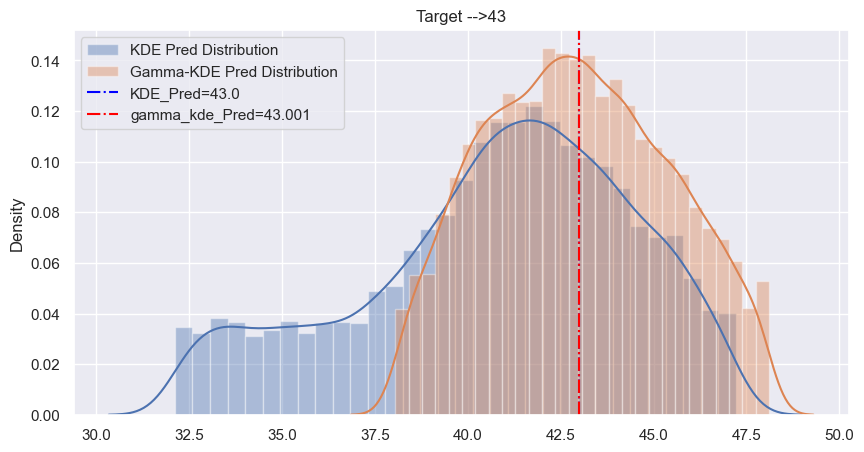

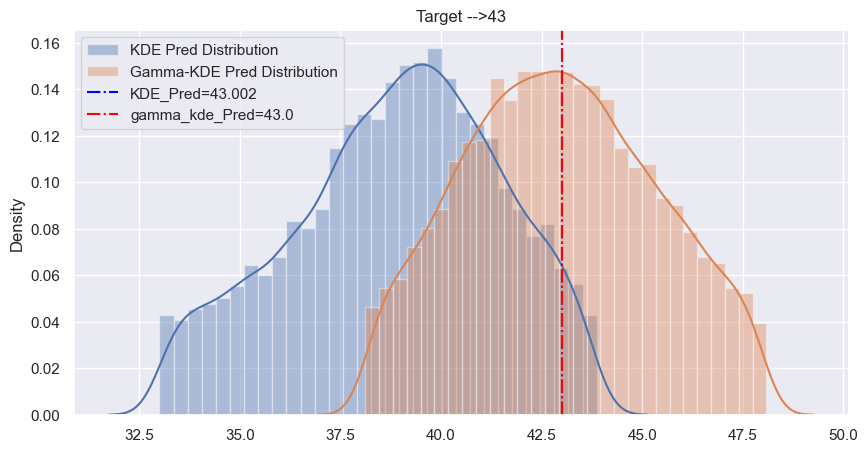

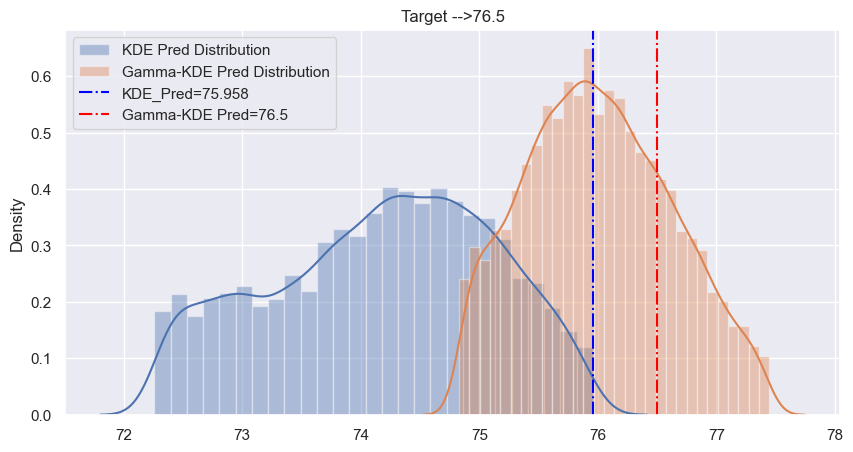

In [31]:
#### 1.) 실시간 수집 데이터 용도에 맞게 정리 
df_MLBX1_inputs,df_MLBX2_inputs,df_FLBX_inputs,df_MLBX1_dl_inputs,df_MLBX2_dl_inputs,df_FLBX_dl_inputs,current_inputs,recent_mlbx1_std,recent_mlbx2_std,recent_flbx_std = get_data_by_id(_id)
input_data = current_inputs
display(input_data)

#### 2.) 예측용 입력값 정의 
df_MLBX1_inputs_direct = df_MLBX1_inputs.reset_index(drop=True) 
df_MLBX2_inputs_direct = df_MLBX2_inputs.reset_index(drop=True) 
df_FLBX_inputs_direct = df_FLBX_inputs.reset_index(drop=True)

#### 3.) 현재 ML공급유량 & FL_BRIX 농도 정의 
current_ML_BX1 = input_data['SATURATOR1_ML_SUPPLY_F_PV_value'].iloc[-1]
current_ML_BX2 = input_data['SATURATOR2_ML_SUPPLY_F_PV_value'].iloc[-1]
current_FL_BX = input_data['EV_02_FL_BRIX_value'].iloc[-1]
print('현재 입력값 ==> ',[current_ML_BX1 , current_ML_BX2 , current_FL_BX])
print('\n')

#### 4.) 실시간 수집된 최근 100개 ML공급유량 & FL_BRIX 농도의 표준편차 계산 
print('최근 100개 Target 표준편차 ==> ',[recent_mlbx1_std ,recent_mlbx2_std ,recent_flbx_std])
print('\n')

#### 5.) 10분 이후 목표품질인 ML공급유량 & FL_BRIX 농도 정의  
target_ML_BX1 = target1
target_ML_BX2 = target2
target_FL_BX = target3
print('10분 뒤 목표값 ==> ',[target_ML_BX1 ,target_ML_BX2 ,target_FL_BX])
print('\n')

#### 6.) ML 예측 진행 
predictions_mlbx1_tree = activate_tree_models(df_MLBX1_inputs_direct,'SATURATOR1_ML_SUPPLY_F_PV_value','ML_BX1',['0.015','0.5','0.985'])
predictions_mlbx2_tree = activate_tree_models(df_MLBX2_inputs_direct,'SATURATOR2_ML_SUPPLY_F_PV_value','ML_BX2',['0.015','0.5','0.985'])
predictions_flbx_tree = activate_tree_models(df_FLBX_inputs_direct,'EV_02_FL_BRIX_value','FL_BX',['0.01','0.5','0.99'])

#### 7.) DL 예측 진행 
predictions_mlbx1_dl = predict_dl(df_MLBX1_dl_inputs,'SATURATOR1_ML_SUPPLY_F_PV_value','ML_BX_1',14,recent_std=None)
predictions_mlbx2_dl = predict_dl(df_MLBX2_dl_inputs,'SATURATOR2_ML_SUPPLY_F_PV_value','ML_BX_2',20,recent_std=None)
predictions_flbx_dl = predict_dl(df_FLBX_dl_inputs,'EV_02_FL_BRIX_value','FL_BX',14,recent_std=recent_flbx_std)

#### 8.) 각 품질예측 당 KDE분포 생성 & 목표값 대비 최소 같거나 큰 1차 KDE예측값 선택 
pred_1,filtered_kde_1 = kde_prediction(predictions_mlbx1_tree,predictions_mlbx1_dl,target_ML_BX1,'ML_BX_1')
pred_2,filtered_kde_2 = kde_prediction(predictions_mlbx2_tree,predictions_mlbx2_dl,target_ML_BX2,'ML_BX_2')
pred_3,filtered_kde_3 = kde_prediction(predictions_flbx_tree,predictions_flbx_dl,target_FL_BX,'FL_BX')

#### 9.) 각 KDE예측값 & 실시간 100개 품질 데이터의 Std 기반 Gamma-KDE분포 생성 --> 2차 Gamma-KDE예측값 선택 
final_pred1,filtered_gamma_kde1 = gamma_kde_prediction(pred_1,recent_mlbx1_std,target_ML_BX1)
final_pred2,filtered_gamma_kde2 = gamma_kde_prediction(pred_2,recent_mlbx2_std,target_ML_BX2)
final_pred3,filtered_gamma_kde3 = gamma_kde_prediction(pred_3,recent_flbx_std,target_FL_BX)

#### 10.) 각 KDE예측값 & 실시간 100개 품질 데이터의 Std 기반 Gamma-KDE분포 생성 --> 2차 Gamma-KDE예측값 선택 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)
plt.figure(figsize=(10,5))
plt.title('Target -->'+str(target1))
plt.grid(True)
sns.distplot(filtered_kde_1,label='KDE Pred Distribution')
sns.distplot(filtered_gamma_kde1, label='Gamma-KDE Pred Distribution')
plt.axvline(pred_1,linestyle='dashdot',color='blue',label='KDE_Pred='+str(np.round(pred_1,3)))
plt.axvline(final_pred1,linestyle='dashdot',color='red',label='gamma_kde_Pred='+str(np.round(final_pred1,3)))
plt.legend()

#### 11.) 목표값 기반 [Pred --> KDE --> Gamma KDE] 최적 근사예측값 탐색 결과 예시  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)
plt.figure(figsize=(10,5))
plt.title('Target -->'+str(target2))
plt.grid(True)
sns.distplot(filtered_kde_2,label='KDE Pred Distribution')
sns.distplot(filtered_gamma_kde2, label='Gamma-KDE Pred Distribution')
plt.axvline(pred_2,linestyle='dashdot',color='blue',label='KDE_Pred='+str(np.round(pred_2,3)))
plt.axvline(final_pred2,linestyle='dashdot',color='red',label='gamma_kde_Pred='+str(np.round(final_pred2,3)))
plt.legend()


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)
plt.figure(figsize=(10,5))
plt.title('Target -->'+str(target3))
plt.grid(True)
sns.distplot(filtered_kde_3,label='KDE Pred Distribution')
sns.distplot(filtered_gamma_kde3, label='Gamma-KDE Pred Distribution')
plt.axvline(pred_3,linestyle='dashdot',color='blue',label='KDE_Pred='+str(np.round(pred_3,3)))
plt.axvline(final_pred3,linestyle='dashdot',color='red',label='Gamma-KDE Pred='+str(np.round(final_pred3,3)))
plt.legend()